In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco

onehot_data = np.load('extracted_onehot.npy')[:,:]
hypothetical_data = np.load('extracted_hypothetical_scores.npy')[:,:]
meannorm_hypothetical_data = (hypothetical_data
                              -np.mean(hypothetical_data, axis=-1)[:,:,None])
contrib_data = np.load('extracted_contrib_scores.npy')[:,:]
#perposimp_hypmeannorm = np.sum(meannorm_hypothetical_data*onehot_data,axis=-1)
perposimp = np.sum(contrib_data*onehot_data,axis=-1)

flanksize=20
contrib_scores_track = modisco.core.DataTrack(name="contrib_scores",
                                 fwd_tracks=contrib_data,
                                 rev_tracks=contrib_data[:,::-1, ::-1])
hypcontrib_scores_track = modisco.core.DataTrack(name="hypcontrib_scores",
                                    fwd_tracks=hypothetical_data,
                                    rev_tracks=hypothetical_data[:,::-1, ::-1])
meannorm_hypcontrib_scores_track = modisco.core.DataTrack(name="meannorm_hypcontrib_scores",
                                    fwd_tracks=meannorm_hypothetical_data,
                                    rev_tracks=meannorm_hypothetical_data[:,::-1, ::-1])
onehot_track = modisco.core.DataTrack(
                 name="onehot", fwd_tracks=onehot_data,
                 rev_tracks=onehot_data[:,::-1, ::-1])
track_set = modisco.core.DataTrackSet(data_tracks=[
                contrib_scores_track, hypcontrib_scores_track,
                meannorm_hypcontrib_scores_track, onehot_track
               ])

coords = []
for example_idx in range(len(onehot_data)):
    #figure out the 6bp window with highest imp
    padded_cumsum = np.array([0]+list(np.cumsum(perposimp[example_idx][50:50+41])))
    sliding_window_imp = padded_cumsum[7:] - padded_cumsum[:-7]
    start = np.argmax(sliding_window_imp)+50
    coords.append(modisco.core.Coordinate(
                    example_idx=example_idx, start=start-17,
                    end=start+24, is_revcomp=False))

all_seqlets = [x for x in track_set.create_seqlets(coords=coords, flanks=30)
               if np.sum(x["contrib_scores"].corefwd) > 0]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


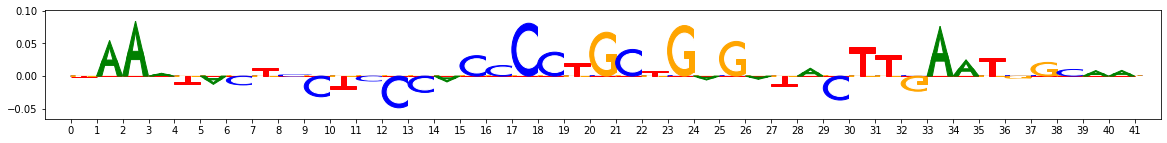

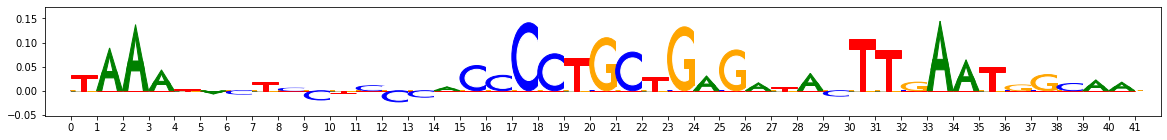

In [3]:
from modisco.visualization import viz_sequence
idx=7
viz_sequence.plot_weights(all_seqlets[idx]["contrib_scores"].corefwd)
viz_sequence.plot_weights(all_seqlets[idx]["meannorm_hypcontrib_scores"].corefwd 
                          *all_seqlets[idx]["onehot"].corefwd)

In [4]:
seqlets_subsample = [all_seqlets[i] for i in np.random.RandomState(1).choice(
                     np.arange(len(all_seqlets)), size=5000,replace=False)]

In [5]:
len(seqlets_subsample)

5000

In [6]:
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.util
reload(modisco.util)
import gc
gc.collect()

min_overlap_frac=0.75
pair_sim_metric = modisco.util.l1norm_contin_jaccard_sim
affmat_computer = modisco.affinitymat.SequenceAffmatComputer_Impute(
                    pair_sim_metric=pair_sim_metric,
                    n_jobs=8, min_overlap_frac=min_overlap_frac)

In [7]:
"""affmat, offsets, isfwdmat = affmat_computer(seqlets_subsample, onehot_trackname="onehot",
                                            hyp_trackname="meannorm_hypcontrib_scores")

np.save("meannormcontribs_affmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", affmat)
np.save("meannormcontribs_offsets_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", offsets)
np.save("meannormcontribs_isfwdmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", isfwdmat)"""

'affmat, offsets, isfwdmat = affmat_computer(seqlets_subsample, onehot_trackname="onehot",\n                                            hyp_trackname="meannorm_hypcontrib_scores")\n\nnp.save("meannormcontribs_affmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", affmat)\nnp.save("meannormcontribs_offsets_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", offsets)\nnp.save("meannormcontribs_isfwdmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", isfwdmat)'

In [7]:
import numpy as np

#affmat = np.load("meannormcontribs_affmat_recenter_41bpseqlets_0.75.npy")
#offsets = np.load("meannormcontribs_offsets_recenter_41bpseqlets_0.75.npy")
#isfwdmat = np.load("meannormcontribs_isfwdmat_recenter_41bpseqlets_0.75.npy")

affmat = np.load("affmat_recenter_41bpseqlets_0.75.npy")
offsets = np.load("offsets_recenter_41bpseqlets_0.75.npy")
isfwdmat = np.load("isfwdmat_recenter_41bpseqlets_0.75.npy")

In [8]:
np.sum(np.isnan(affmat))/len(np.ravel(affmat))

0.0

In [ ]:
import modisco.core
reload(modisco.core)
import modisco.affinitymat
reload(modisco.affinitymat)

flatten = 1
distmat = np.log(1.0/(flatten*np.maximum(affmat,1e-7)) - (1.0/flatten - 1))

n_neighbors = 30
tsne_adapted = modisco.affinitymat.tsne_density_adaptation(dist_mat=distmat,
                                                           perplexity=n_neighbors)
#tsne_adapted = tsne_adapted + np.eye(len(tsne_adapted))*np.max(tsne_adapted, axis=-1)
current_affmat = (tsne_adapted*tsne_adapted.T)
#current_affmat = (tsne_adapted + tsne_adapted.T)/2.0
#make sure there is a self-similarity so there's a reason to leave things in their own cluster
currentaffmatmethod = "tsne-mulT"

#get the number of examples that contain x% of the probability density
"""from matplotlib import pyplot as plt

tsne_adapted_sorted_cumsum = np.cumsum(np.sort(tsne_adapted, axis=-1)[:,::-1],axis=-1)
for percent in [0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999, 1.0]:
    print(percent)
    num_with_density = np.sum(tsne_adapted_sorted_cumsum <= percent, axis=-1)
    print(np.median(num_with_density))
    plt.hist(num_with_density, bins=100)
    plt.show()"""
    

In [ ]:
"""nneighb_affmat = nearest_neighb_affmat(affmat=affmat, n_neighbs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
current_affmat = nneighb_affmat*nneighb_affmat.T
currentaffmatmethod = "nneigh-mulT" """

In [ ]:
"""reload(modisco.affinitymat)
nneighb_affmat = modisco.affinitymat.nearest_neighb_affmat_expo_decay(affmat=affmat, n_neighb=50, beta=0.1)
current_affmat = nneighb_affmat*nneighb_affmat.T
currentaffmatmethod = "nneigh-expo-mulT" """

In [9]:
from collections import Counter
reload(modisco.affinitymat)
from modisco.affinitymat import nearest_neighb_affmat
from modisco.affinitymat import get_diffusion_distances
import sklearn.cluster
import scipy

nneighb_affmat = nearest_neighb_affmat(affmat=affmat, n_neighbs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
dmap = np.real(modisco.affinitymat.get_concat_dmap_coords(affmat=nneighb_affmat, ts=[3],
                                                          k=int(len(nneighb_affmat)/50)))
distmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(dmap, metric='euclidean'))
current_affmat = 1.0/np.exp(distmat)
currentaffmatmethod = "nneigh-diffusionmap"

Doing eigendecomposition
Did eigendecomposition in 50.951575756073


In [10]:
"""kmeans_clustdist = sklearn.cluster.KMeans(n_clusters=int(len(nneighb_affmat)/100),
                                          n_init=100, random_state=1234).fit_transform(dmap)
the_clustering = np.argmin(kmeans_clustdist,axis=-1)"""

import leidenalg
from collections import Counter

print("affmat method",currentaffmatmethod)

#current_affmat = current_affmat*(1-np.eye(len(current_affmat)))

#get Leiden averaged over different seeds
averaging_rounds = 0
#keep top 5% for speed
current_affmat = current_affmat*(current_affmat>np.percentile(current_affmat.ravel(), q=95))
for round_num in range(averaging_rounds):
    current_affmat = modisco.affinitymat.average_over_different_seeds(
                        affmat=current_affmat,
                        clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                partitiontype=leidenalg.ModularityVertexPartition,
                                                n_iterations=1),
                        nseeds=200)

the_clustering = modisco.affinitymat.take_best_over_different_seeds(affmat=current_affmat,
                                                clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                    partitiontype=leidenalg.ModularityVertexPartition,
                                                    n_iterations=-1),
                                                nseeds=10)
print(Counter(the_clustering))

affmat method nneigh-diffusionmap


Quality: 0.28255306400100744
Quality: 0.2825557444118298
Quality: 0.2825606732643218

Counter({0: 1719, 1: 897, 2: 636, 3: 488, 4: 247, 5: 203, 6: 184, 7: 96, 8: 43, 9: 33, 10: 32, 11: 26, 12: 23, 13: 21, 14: 20, 15: 20, 16: 17, 17: 13, 18: 11, 19: 10, 20: 8, 22: 8, 21: 8, 23: 7, 24: 6, 25: 6, 26: 6, 28: 5, 27: 5, 29: 4, 30: 4, 31: 3, 35: 2, 32: 2, 46: 2, 42: 2, 45: 2, 38: 2, 37: 2, 33: 2, 34: 2, 43: 2, 36: 2, 49: 2, 41: 2, 47: 2, 40: 2, 39: 2, 48: 2, 44: 2, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 120: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 121: 1, 122: 1, 123

In [11]:
reload(modisco.core)
import modisco.visualization
from modisco.visualization import viz_sequence
from collections import OrderedDict


def get_aggregated_seqlet(seqlets, in_cluster_mask, onehot_trackname,
                          hyp_trackname, flanklen, min_overlap_frac, pair_sim_metric):
    seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets])[in_cluster_mask]
    seqlets_sortinfo = np.argsort(seqletimps)
    seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in
                                          zip(seqlets, in_cluster_mask) if incluster]
    seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in seqlets_sortinfo]
    
    aggregated_seqlet = modisco.core.create_aggregated_seqlet(
                         sorted_seqlets=seqlets_in_cluster_allfwd,
                         onehot_trackname=onehot_trackname,
                         hyp_trackname=hyp_trackname, flanklen=flanklen,              
                         min_overlap_frac=min_overlap_frac,
                         pair_sim_metric=pair_sim_metric)
    
    inverse_sortinfo = np.zeros(len(seqlets_sortinfo)).astype("int64")
    inverse_sortinfo[seqlets_sortinfo] = np.arange(len(seqlets_sortinfo))
    return aggregated_seqlet, inverse_sortinfo


#set the cluster to -1 for all cases with fewer than min_cluster_size in the cluster
def refine_clusters_by_size(the_clustering, min_cluster_size):
    new_clustering = np.ones_like(the_clustering)*-1
    for idx in range(0, max(the_clustering)+1):
        in_cluster_mask = idx==the_clustering
        num_in_cluster = sum(in_cluster_mask)
        if (num_in_cluster >= min_cluster_size):
            new_clustering[in_cluster_mask] = idx
    return new_clustering


def get_ic_weighting(aggregated_seqlet, onehot_trackname, minperposcountfrac):
    per_pos_ic = modisco.util.compute_per_position_ic(
                            #note that I'm normalizing aggregated_seqlet[onehot_trackname].fwd to
                            # sum to 1 at each position because otherwise the ic calc is affected.
                            ppm=(aggregated_seqlet[onehot_trackname].fwd/
                                 np.sum(aggregated_seqlet[onehot_trackname].fwd, axis=-1)[:,None]),
                            background=np.array([0.27, 0.23, 0.23, 0.27]),
                            pseudocount=0.001)
    perpos_count_frac_support = (aggregated_seqlet.position_counts/np.max(
                                    aggregated_seqlet.position_counts))
    perpos_count_meetsthresh = perpos_count_frac_support > minperposcountfrac
    ic_weighting = per_pos_ic*perpos_count_meetsthresh
    ic_weighting = ic_weighting/np.sum(ic_weighting)
    return ic_weighting


def create_weighted_seqlet(seqlet, flank_size, weighting_inc_flanks, onehot_trackname, hyp_trackname):
    new_seqlet = modisco.core.Seqlet(coor=seqlet.coor)
    new_hyp_seqletdata = modisco.core.SeqletData(
                            left_flank=flank_size, right_flank=flank_size,
                            fwd=seqlet[hyp_trackname].get_core_with_flank(
                                    left=flank_size, right=flank_size, is_revcomp=False),
                            rev=seqlet[hyp_trackname].get_core_with_flank(
                                    left=flank_size, right=flank_size, is_revcomp=True))
    new_seqlet[hyp_trackname] = new_hyp_seqletdata
    fwd_onehot = seqlet[onehot_trackname].get_core_with_flank(
                    left=flank_size, right=flank_size, is_revcomp=False)
    rev_onehot = seqlet[onehot_trackname].get_core_with_flank(
                    left=flank_size, right=flank_size, is_revcomp=True)
    masked_fwd_onehot = fwd_onehot*weighting_inc_flanks[:,None]
    masked_rev_onehot = rev_onehot*weighting_inc_flanks[::-1][:,None]
    new_seqlet[onehot_trackname] = modisco.core.SeqletData(
                                        left_flank=flank_size, right_flank=flank_size,
                                        fwd=masked_fwd_onehot, rev=masked_rev_onehot)
    return new_seqlet


#get exemplars where the one-hot encoding is weighted by the information content
# of the aggregate motif
def get_exemplars(the_clustering, distmat, isfwdmat, offsets,
                  seqlets_per_exemplar,
                  onehot_trackname,
                  hyp_trackname,
                  minperposcountfrac=0.8, flank_size=20):
    cluster_idx_to_weighted_exemplars = OrderedDict()
    cluster_idx_to_unweighted_exemplars = OrderedDict()
    cluster_idx_to_aggregated_seqlet = OrderedDict()
    for cluster_idx in range(max(the_clustering)+1):
        in_cluster_mask = cluster_idx==the_clustering
        if (sum(in_cluster_mask) > 0):
            num_exemplars_for_cluster = int(np.ceil(sum(in_cluster_mask)/seqlets_per_exemplar))
            #get the indices of the exemplars relative to the within-cluster set
            rel_exemplar_indices = modisco.util.facility_locator(
                distmat=distmat[in_cluster_mask][:,in_cluster_mask],
                num_exemplars=num_exemplars_for_cluster)
            #get the aggregated seqlet, as well as the mapping from
            # rel_idx --> idx_of_seqlet_in aggregated_seqlet.seqlets
            aggregated_seqlet, rel_idx_to_sorted_idx = get_aggregated_seqlet(
                seqlets=seqlets_subsample, in_cluster_mask=in_cluster_mask,
                onehot_trackname="onehot", hyp_trackname="hypcontrib_scores",
                flanklen=flanksize, min_overlap_frac=min_overlap_frac,
                pair_sim_metric=pair_sim_metric)
            cluster_idx_to_aggregated_seqlet[cluster_idx] = aggregated_seqlet
            #print(cluster_idx)
            #viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
            #Get the information-content-based weighting of positions in the
            # aggregated seqlet
            ic_weighting = get_ic_weighting(aggregated_seqlet=aggregated_seqlet,
                                            onehot_trackname=onehot_trackname,
                                            minperposcountfrac=minperposcountfrac)
            weighted_exemplar_seqlets = []
            unweighted_exemplar_seqlets = []
            #iterate over the exemplars, weight by ic, create new "weighted" exemplars
            for rel_exemplar_idx in rel_exemplar_indices:
                exemplar_seqlet = aggregated_seqlet.seqlets[rel_idx_to_sorted_idx[rel_exemplar_idx]]
                offset_wrt_aggseqlet_start = aggregated_seqlet.offsets[rel_idx_to_sorted_idx[rel_exemplar_idx]]
                #pad with zeros as needed to reach the target flank length
                ic_weight_at_exemplar_inc_flanks = np.concatenate(
                    [np.zeros(max(flank_size-offset_wrt_aggseqlet_start,0)),
                     ic_weighting[
                        max(offset_wrt_aggseqlet_start-flank_size,0):
                        offset_wrt_aggseqlet_start+len(exemplar_seqlet)+flank_size],
                     np.zeros(max(flank_size - 
                                 (len(ic_weighting)-(offset_wrt_aggseqlet_start
                                                     +len(exemplar_seqlet))),0))],axis=0)
                #normalize to sum to 1
                ic_weight_at_exemplar_inc_flanks = (
                        ic_weight_at_exemplar_inc_flanks/np.sum(ic_weight_at_exemplar_inc_flanks))
                weighted_exemplar_seqlet = create_weighted_seqlet(
                    seqlet=exemplar_seqlet, flank_size=flank_size,
                    weighting_inc_flanks=ic_weight_at_exemplar_inc_flanks,
                    onehot_trackname=onehot_trackname,
                    hyp_trackname=hyp_trackname)
                weighted_exemplar_seqlets.append(weighted_exemplar_seqlet)
                unweighted_exemplar_seqlets.append(exemplar_seqlet)
            cluster_idx_to_weighted_exemplars[cluster_idx] = weighted_exemplar_seqlets
            cluster_idx_to_unweighted_exemplars[cluster_idx] = unweighted_exemplar_seqlets
    return cluster_idx_to_aggregated_seqlet, cluster_idx_to_weighted_exemplars, cluster_idx_to_unweighted_exemplars


def core_refine_cluster_by_within_v_out_similarity(within_cluster_sims, outside_cluster_sims,
                                                   within_to_within_percentile, within_to_out_percentile):
    assert within_cluster_sims.shape[0] == outside_cluster_sims.shape[0]
    within_to_within = np.percentile(a=within_cluster_sims, q=within_to_within_percentile, axis=-1)
    within_to_out = np.percentile(a=outside_cluster_sims, q=within_to_out_percentile, axis=-1)
    #within_to_within = np.median(a=within_cluster_sims, axis=-1)
    #within_to_out = np.median(a=outside_cluster_sims, axis=-1)
    #within_to_within = np.mean(a=within_cluster_sims, axis=-1)
    #within_to_out = np.mean(a=outside_cluster_sims, axis=-1)
    
    #discard any seqlets where the median similarity to the outside exceeds the median sim to the inside
    #sort the seqlets in descending order of their within-cluster similarity, then march down the list until
    # we get into the situation where the min median similarity of some seqlet to within the cluster is less than
    # the max median similarity of some seqlet (seen so far) to outside the cluster.
    #Only retain the set of seqlets such that the min median similarity within the cluster exceeds
    # the max median similarity outside the cluster
    argsort_desc_within_to_within = np.argsort(within_to_within)[::-1]
    sorted_desc_within_to_within = within_to_within[argsort_desc_within_to_within]
    corresp_within_to_out = within_to_out[argsort_desc_within_to_within] #corresponding within-to-out
    runningmin_sorted_desc_within_to_within = np.minimum.accumulate(sorted_desc_within_to_within)
    runningmax_corresp_within_to_out = np.maximum.accumulate(corresp_within_to_out)
    
    #print(runningmin_sorted_desc_within_to_within)
    #print(runningmax_corresp_within_to_out)
    #print(runningmin_sorted_desc_within_to_within-runningmax_corresp_within_to_out)
    
    #get the last rank that passes the condition
    last_passing_rank = [x[0] for x in enumerate(runningmin_sorted_desc_within_to_within
                                                 -runningmax_corresp_within_to_out)
                        if x[1] > 0][-1]
    #get the indices (relative to the things in the cluster) corresponding to that rank
    relative_passing_indices = argsort_desc_within_to_within[0:last_passing_rank+1]
    relative_skipped_indices = argsort_desc_within_to_within[last_passing_rank+1:]
    return relative_passing_indices, relative_skipped_indices


def refine_clusters_by_within_v_out_similarity(affmat, the_clustering,
                                               within_to_within_percentile, within_to_out_percentile):
    new_clustering = np.ones_like(the_clustering)*-1
    exclusion_log = {} #log which indices got dropped from a cluster
    for idx in range(0, max(the_clustering)+1):
        print("idx",idx)
        in_cluster_mask = idx==the_clustering
        in_cluster_indices = np.arange(len(the_clustering))[in_cluster_mask]
        within_cluster_sims = affmat[in_cluster_mask][:,in_cluster_mask]
        outside_cluster_sims = affmat[in_cluster_mask][:,in_cluster_mask==False]
        relative_passing_indices, relative_skipped_indices = core_refine_cluster_by_within_v_out_similarity(
            within_cluster_sims=within_cluster_sims,
            outside_cluster_sims=outside_cluster_sims,
            within_to_within_percentile=within_to_within_percentile,
            within_to_out_percentile=within_to_out_percentile)
        passing_indices = in_cluster_indices[relative_passing_indices]
        skipped_indices = in_cluster_indices[relative_skipped_indices]
        new_clustering[passing_indices] = idx
        exclusion_log[idx] = skipped_indices
    return new_clustering, exclusion_log


def repeated_refine_clusters_by_within_v_out_similarity(affmat, the_clustering,
                                                        within_to_within_percentile, within_to_out_percentile):
    #repeatedly call the refinement step until convergence
    keep_going = True
    round_num = 0
    net_exclusion_log = {}
    while (keep_going):
        print("refinement round",round_num)
        the_clustering, exclusion_log = refine_clusters_by_within_v_out_similarity(
                                          affmat, the_clustering,
                                          within_to_within_percentile=within_to_within_percentile,
                                          within_to_out_percentile=within_to_out_percentile)
        for idx in exclusion_log:
            if idx not in net_exclusion_log:
                net_exclusion_log[idx] = []
            net_exclusion_log[idx].extend(exclusion_log[idx])
        num_pruned = sum([len(x) for x in exclusion_log.values()])
        print("Pruned",num_pruned,"seqlets")
        if (num_pruned==0):
            keep_going = False
        round_num += 1
    return the_clustering, net_exclusion_log


def get_within_cluster_seqlets_sorted_by_within_cluster_sim(affmat, within_cluster_mask):
    indices_in_cluster = np.arange(len(within_cluster_mask))[within_cluster_mask]
    rel_indices_sorted_by_median_within_sim =\
        np.argsort(np.median(affmat[within_cluster_mask][:,within_cluster_mask], axis=-1))[::-1]
    sorted_indices_in_cluster = indices_in_cluster[rel_indices_sorted_by_median_within_sim]
    return sorted_indices_in_cluster

In [12]:
min_cluster_size = 30
refinedbysize_clustering = refine_clusters_by_size(
    the_clustering=the_clustering, min_cluster_size=min_cluster_size)

In [57]:
affmat_for_filtering = affmat#current_affmat
refinedbysizeandsim_clustering, exclusion_log = repeated_refine_clusters_by_within_v_out_similarity(
    affmat=affmat_for_filtering,
    the_clustering=refinedbysize_clustering,
    within_to_within_percentile=100,#50, #when percentile is set to 100, no filtering is done
    within_to_out_percentile=50)
refinedbysize_clustering2 = refine_clusters_by_size(
    the_clustering=refinedbysizeandsim_clustering, min_cluster_size=min_cluster_size)
refined_clustering = refinedbysize_clustering2

refinement round 0
idx 0
idx 1
idx 2
idx 3
idx 4
idx 5
idx 6
idx 7
idx 8
idx 9
idx 10
Pruned 0 seqlets


In [58]:
distmat_for_exemplars = np.log(1.0/(np.maximum(current_affmat,1e-7)))
(clusteridx_to_aggregated_seqlet,
 cluster_to_weighted_exemplars,
 cluster_to_unweighted_exemplars) = get_exemplars(
    the_clustering=refined_clustering, distmat=distmat_for_exemplars,
    isfwdmat=isfwdmat, offsets=offsets, seqlets_per_exemplar=20,
    onehot_trackname="onehot",
    hyp_trackname="hypcontrib_scores")

In [59]:
from matplotlib import pyplot as plt

reload(modisco.util)


def get_scan_scores(seqlets_subsample, contrib_scores_track, onehot_track, weight_mat):
    cosine_sim, imp_score_strength = modisco.util.get_hCWM_scores(
        imp_scores=np.array([x[contrib_scores_track].corefwd for x in seqlets_subsample]),
        onehot_seq=np.array([x[onehot_track].corefwd for x in seqlets_subsample]),
        weightmat=weight_mat)
    return cosine_sim, cosine_sim*imp_score_strength


def get_hCWM_from_agg_seqlet(aggregated_seqlet, contrib_trackname, hyp_trackname, corewindow, flankexpand):
    #percent_support = np.sum(aggregated_seqlet[onehot_trackname].fwd, axis=-1)
    #ic_scores = (modisco.util.compute_per_position_ic(
    #                ppm=aggregated_seqlet[onehot_trackname].fwd,
    #                background=np.array([0.25, 0.25, 0.25, 0.25]), pseudocount=0.001)
    #             *(percent_support > 0.8))
    #plt.plot(ic_scores)
    #(start_idx, end_idx) = modisco.util.trim_from_ends(track=ic_scores, minval=min_ic)
    contrib_scores = aggregated_seqlet[contrib_trackname].fwd
    startidx_corewindow = modisco.util.get_best_fixedsize_window(track=np.sum(contrib_scores, axis=-1),
                                                                 window_size=corewindow)
    hCWM = aggregated_seqlet[hyp_trackname].fwd[startidx_corewindow-flankexpand:
                                                startidx_corewindow+corewindow+flankexpand]
    return hCWM


Cluster idx 0
Num seqlets 1719
Num excluded 0


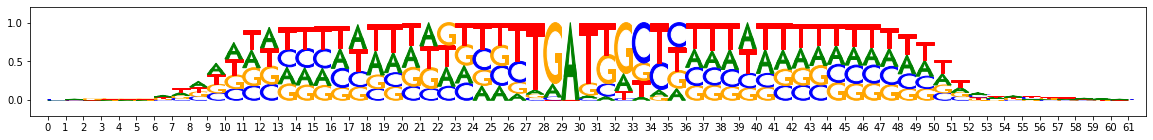

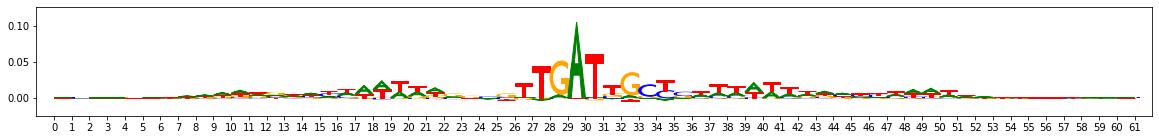

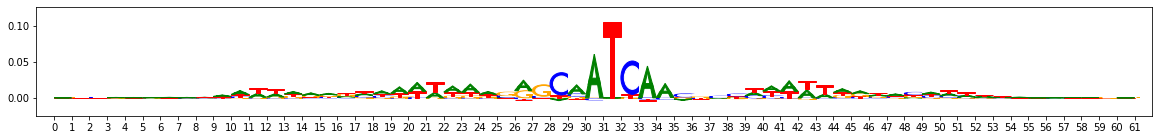

within-to-within and outside-to-within median similarities


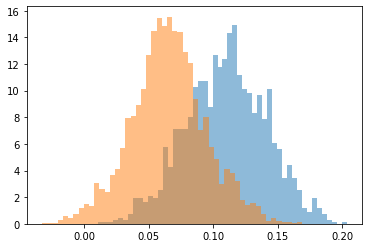

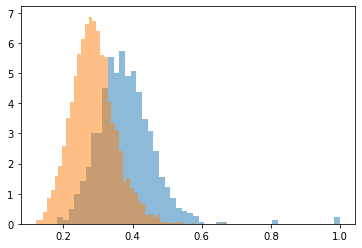

Cluster idx 1
Num seqlets 897
Num excluded 0


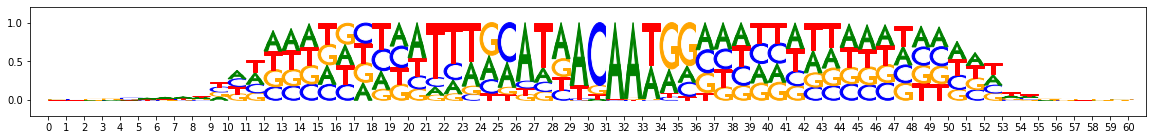

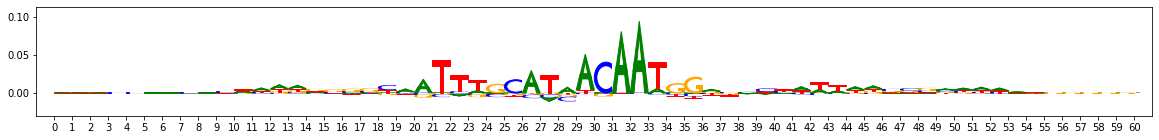

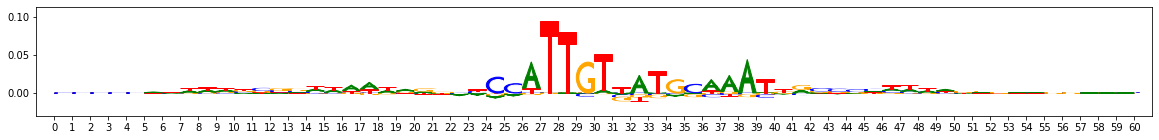

within-to-within and outside-to-within median similarities


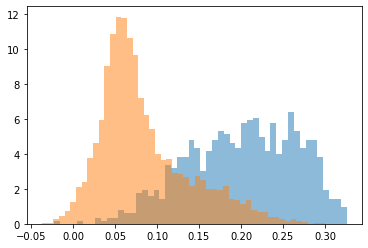

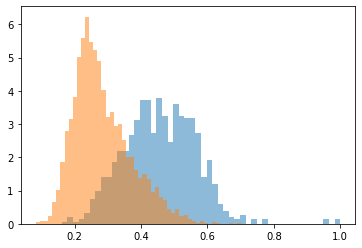

Cluster idx 2
Num seqlets 636
Num excluded 0


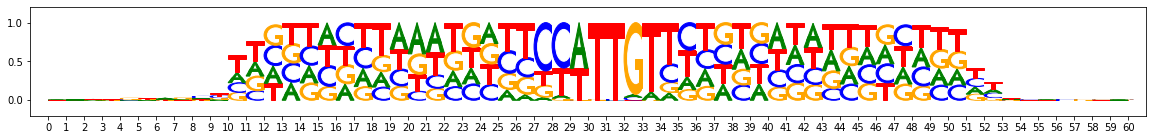

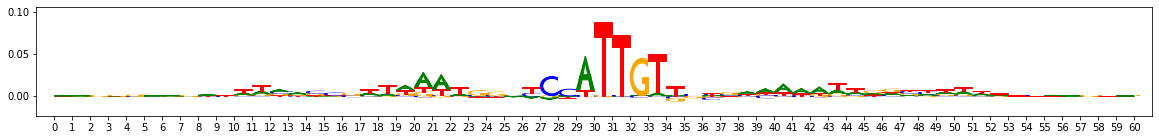

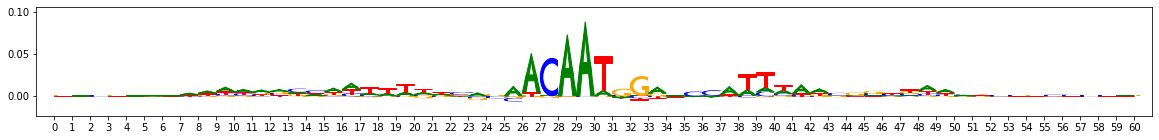

within-to-within and outside-to-within median similarities


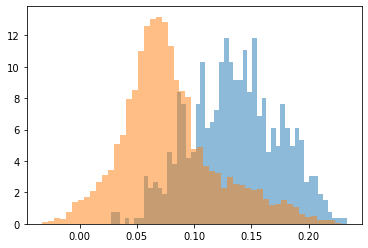

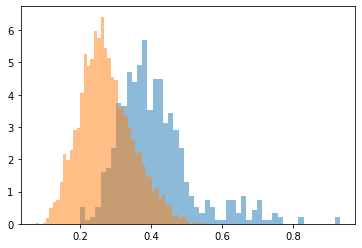

Cluster idx 3
Num seqlets 488
Num excluded 0


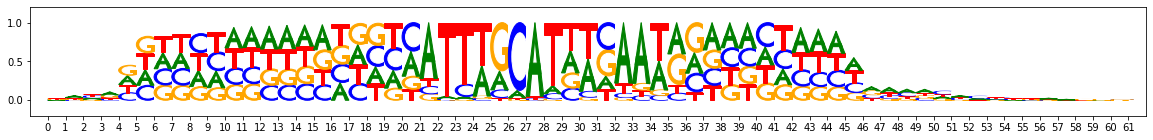

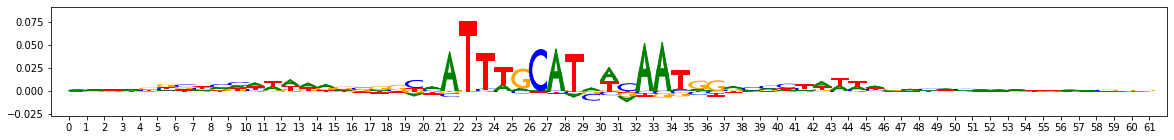

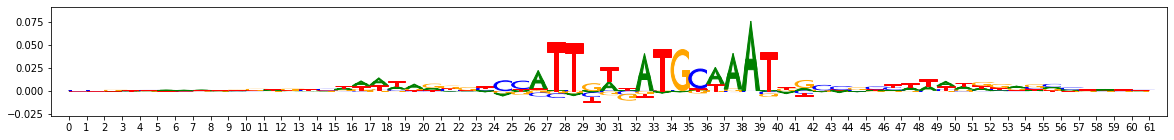

within-to-within and outside-to-within median similarities


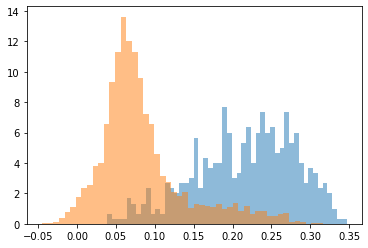

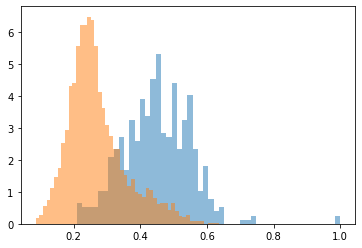

Cluster idx 4
Num seqlets 247
Num excluded 0


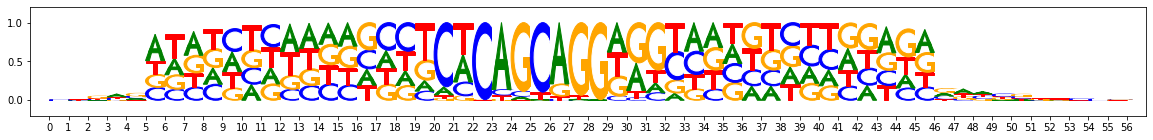

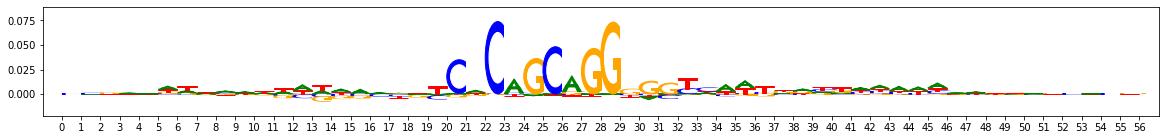

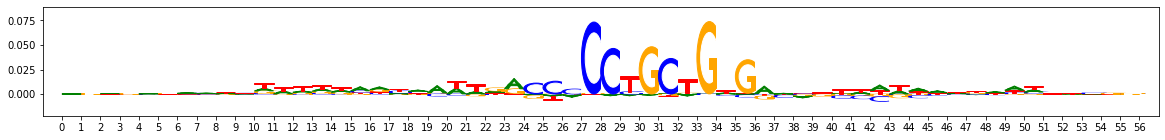

within-to-within and outside-to-within median similarities


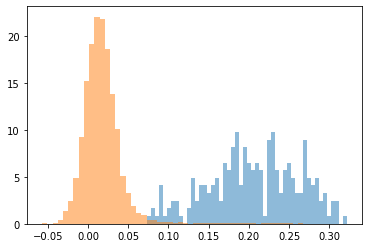

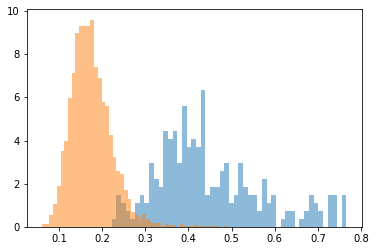

Cluster idx 5
Num seqlets 203
Num excluded 0


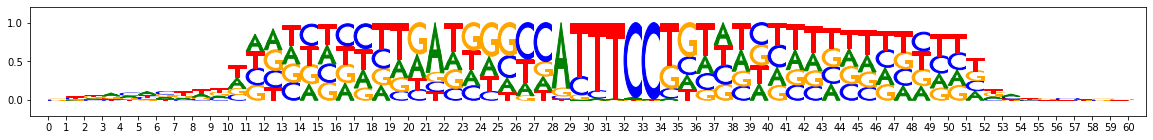

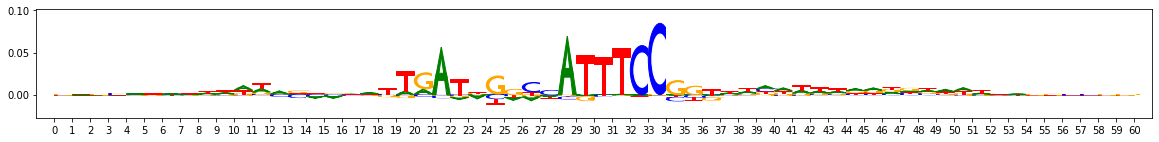

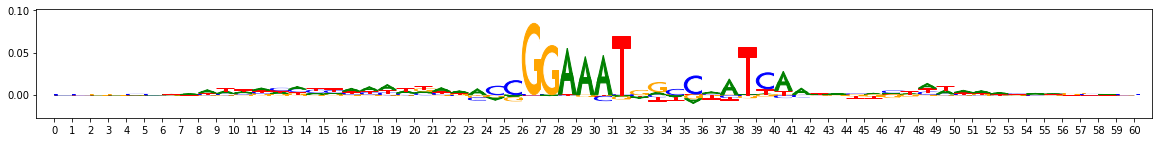

within-to-within and outside-to-within median similarities


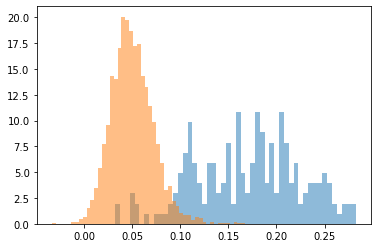

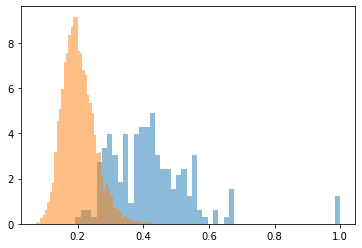

Cluster idx 6
Num seqlets 184
Num excluded 0


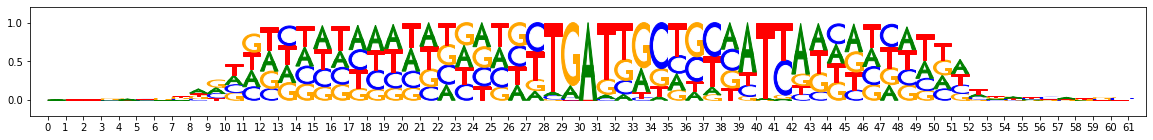

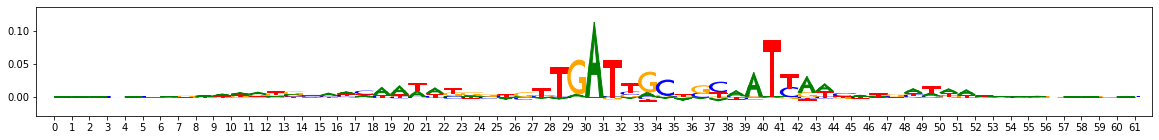

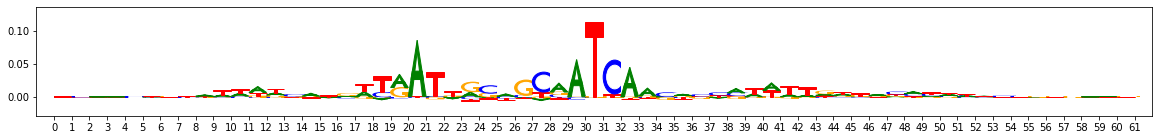

within-to-within and outside-to-within median similarities


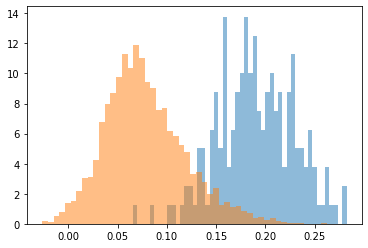

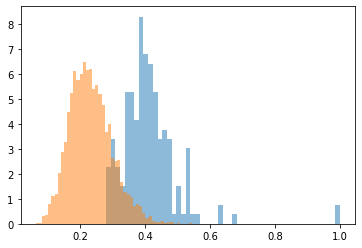

Cluster idx 7
Num seqlets 96
Num excluded 0


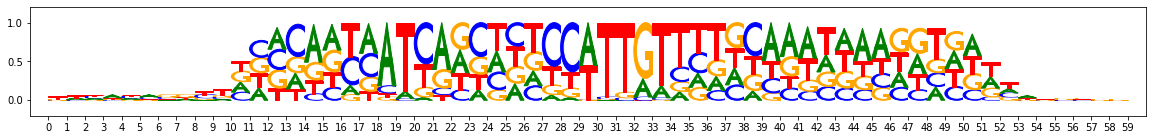

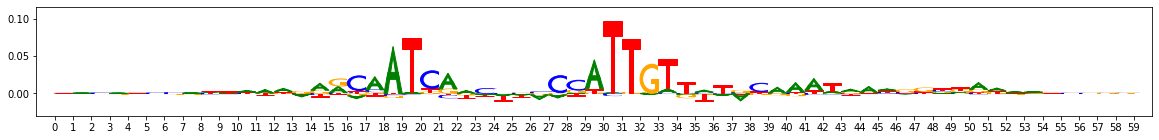

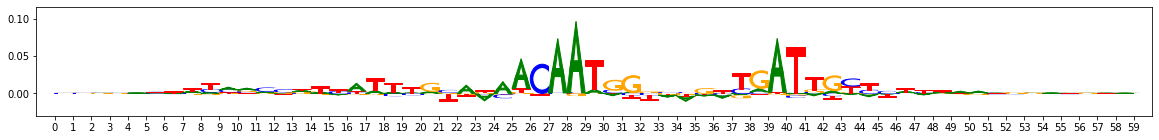

within-to-within and outside-to-within median similarities


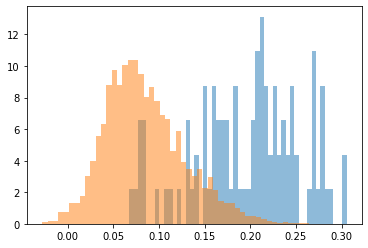

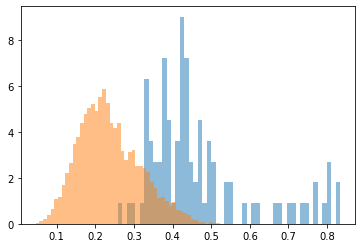

Cluster idx 8
Num seqlets 43
Num excluded 0


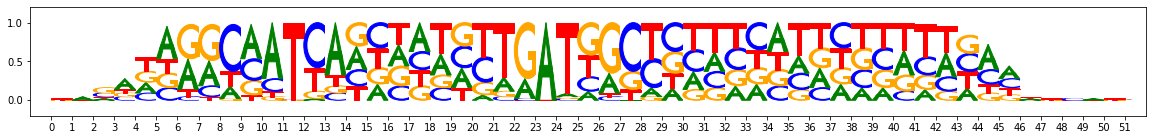

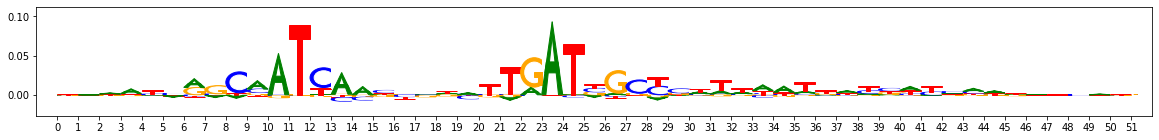

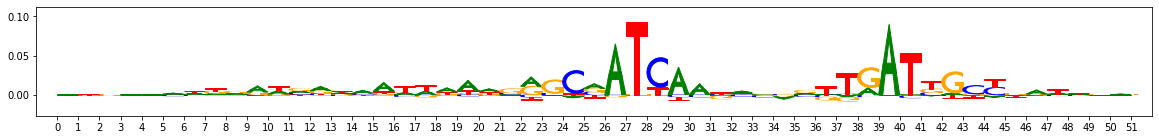

within-to-within and outside-to-within median similarities


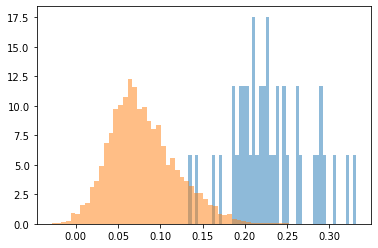

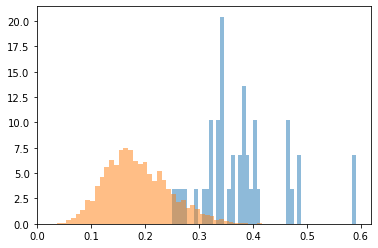

Cluster idx 9
Num seqlets 33
Num excluded 0


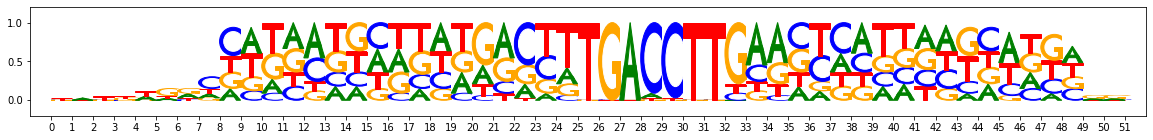

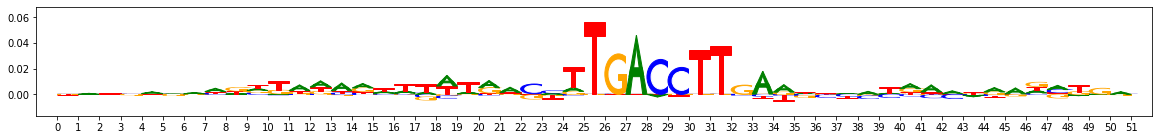

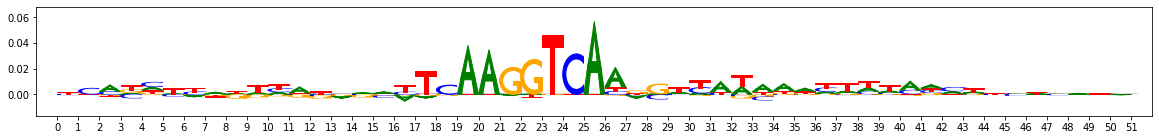

within-to-within and outside-to-within median similarities


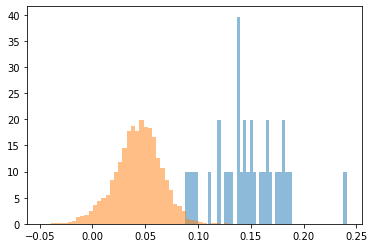

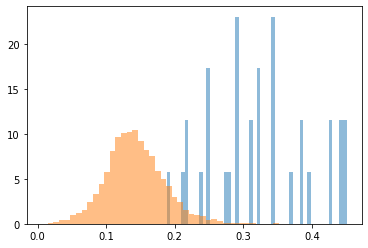

Cluster idx 10
Num seqlets 32
Num excluded 0


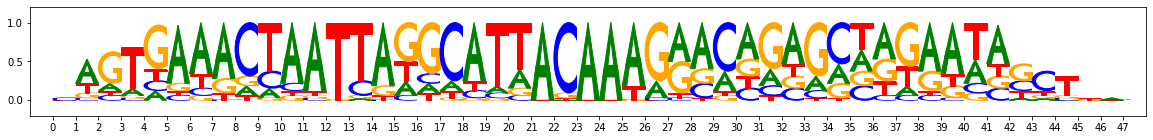

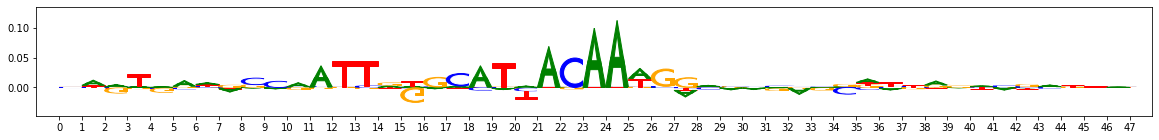

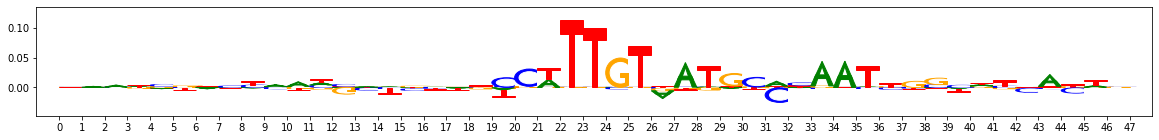

within-to-within and outside-to-within median similarities


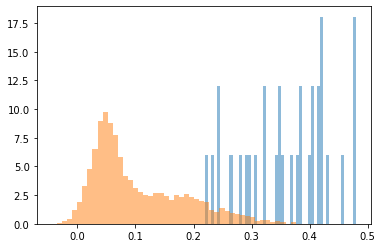

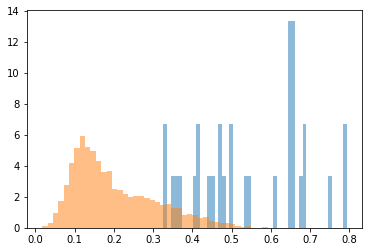

In [60]:
from matplotlib import pyplot as plt
import modisco.util

zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
#check which things got dropped
for cluster_idx in clusteridx_to_aggregated_seqlet:
    within_cluster_mask = refined_clustering==cluster_idx
    if (sum(within_cluster_mask) > 0):
        aggregated_seqlet = clusteridx_to_aggregated_seqlet[cluster_idx]
        #hCWM = get_hCWM_from_agg_seqlet(aggregated_seqlet=aggregated_seqlet,
        #                                contrib_trackname="contrib_scores",
        #                                hyp_trackname="hypcontrib_scores",
        #                                corewindow=7, flankexpand=7)
        #viz_sequence.plot_weights(hCWM)
        #scan all the seqlets, get max projected cosine sim + corresp (projected cosine sim * imp)        
        seqlets_excluded_due_to_poor_sim = exclusion_log[cluster_idx]
        print("Cluster idx", cluster_idx)
        print("Num seqlets", np.sum(within_cluster_mask))
        print("Num excluded", len(seqlets_excluded_due_to_poor_sim))
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].rev)
        print("within-to-within and outside-to-within median similarities")
        median_within_to_within = np.median(affmat[within_cluster_mask][:,within_cluster_mask], axis=-1)
        median_out_to_within = np.median(affmat[within_cluster_mask==False][:,within_cluster_mask], axis=-1)
        max_within_to_within = np.max(zerodiagaffmat[within_cluster_mask][:,within_cluster_mask], axis=-1)
        max_out_to_within = np.max(zerodiagaffmat[within_cluster_mask==False][:,within_cluster_mask], axis=-1)        
        plt.hist(median_within_to_within, bins=50, density=True, alpha=0.5)
        plt.hist(median_out_to_within, bins=50, density=True, alpha=0.5)
        plt.show()
        plt.hist(max_within_to_within, bins=50, density=True, alpha=0.5)
        plt.hist(max_out_to_within, bins=50, density=True, alpha=0.5)
        plt.show()
        
        ##plot top 3 retained
        #print("Seqlets retained - whole spectrum")
        ##sort by median within-cluster sim...I want to know what the best/worst are like
        #sorted_indices_within_cluster = get_within_cluster_seqlets_sorted_by_within_cluster_sim(
        #    affmat=affmat, within_cluster_mask=within_cluster_mask)
        #for seqlet_idx in sorted_indices_within_cluster[::int(len(sorted_indices_within_cluster)/5)]:
        #    viz_sequence.plot_weights(seqlets_subsample[seqlet_idx]["contrib_scores"].corefwd)
        #plot the top 3 excluded
        #print("Example excluded:")
        #for seqlet_idx in seqlets_excluded_due_to_poor_sim[:3]:
        #    viz_sequence.plot_weights(seqlets_subsample[seqlet_idx]["contrib_scores"].corefwd)

In [61]:
#compute exemplar distances
from collections import OrderedDict
import time
cluster_to_weighted_exemplar_sims = OrderedDict()
cluster_to_unweighted_exemplar_sims = OrderedDict()
start = time.time()
for cluster_idx in cluster_to_weighted_exemplars:
    weighted_exemplars = cluster_to_weighted_exemplars[cluster_idx]
    weighted_exemplar_affmat_result = affmat_computer(seqlets=weighted_exemplars,
                                    other_seqlets=seqlets_subsample,
                                    onehot_trackname="onehot",
                                    hyp_trackname="hypcontrib_scores",
                                    verbose=False)
    cluster_to_weighted_exemplar_sims[cluster_idx] = weighted_exemplar_affmat_result
    unweighted_exemplars = cluster_to_unweighted_exemplars[cluster_idx]
    unweighted_exemplar_affmat_result = affmat_computer(seqlets=unweighted_exemplars,
                                    other_seqlets=seqlets_subsample,
                                    onehot_trackname="onehot",
                                    hyp_trackname="hypcontrib_scores",
                                    verbose=False)
    cluster_to_unweighted_exemplar_sims[cluster_idx] = unweighted_exemplar_affmat_result
print("Time taken:", time.time()-start)

Time taken: 186.81269598007202


In [121]:
from matplotlib import pyplot as plt
from modisco.visualization import viz_sequence
from sklearn.metrics import roc_auc_score, average_precision_score
import modisco.util
reload(modisco.util)
import modisco.map_seqlets_to_clusters
reload(modisco.map_seqlets_to_clusters)

cluster_mapper = modisco.map_seqlets_to_clusters.ExemplarBasedSeqletToClusterMapper.build(
                    cluster_to_exemplars=cluster_to_weighted_exemplars,
                    cluster_to_exemplar_sims=cluster_to_weighted_exemplar_sims,
                    orig_cluster_membership=refined_clustering,
                    fprthresh=0.01, tprthresh=0.8, precthresh=0.8,
                    clustersizefoldincreasethresh=4)
exemplarbased_seqlettoclusterscore = (
    cluster_mapper.map_exemplar_sims_to_cluster(
                    cluster_to_exemplar_sims=cluster_to_weighted_exemplar_sims))
exemplarbased_clusterassignment = (
    modisco.map_seqlets_to_clusters.get_clusters_from_seqlettoclusterscore(
                                     exemplarbased_seqlettoclusterscore))

cluster idx: 0
original - num seqlets 1719
fwd


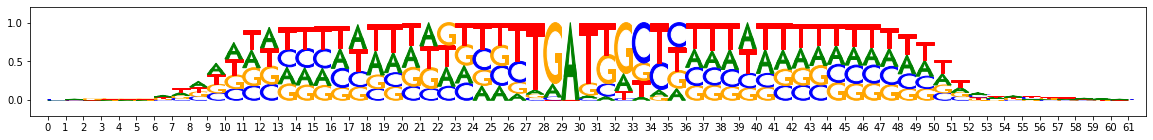

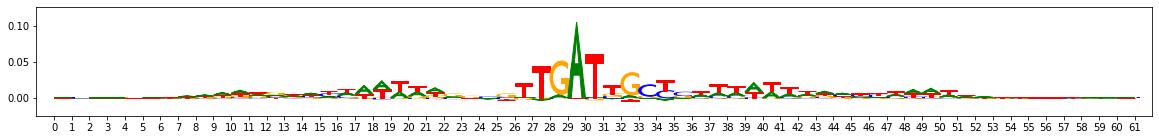

rev


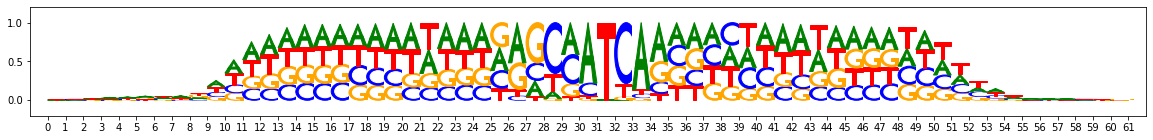

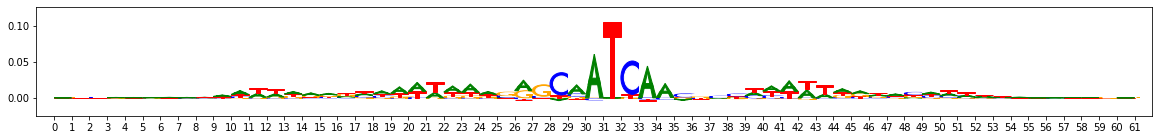

remapped WITHOUT competition - num seqlets 2008


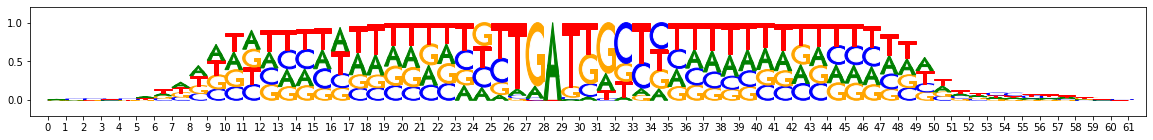

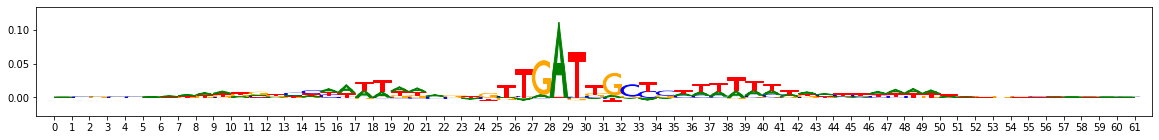

remapped WITH competition - num seqlets 1704


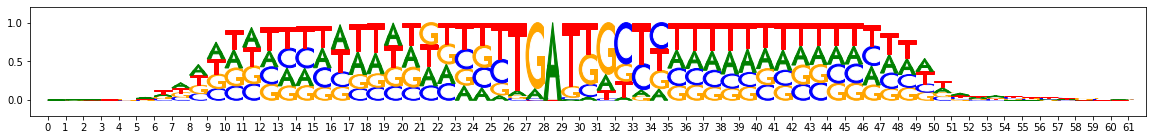

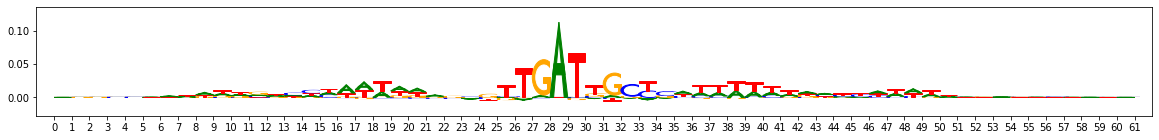

cluster idx: 1
original - num seqlets 897
fwd


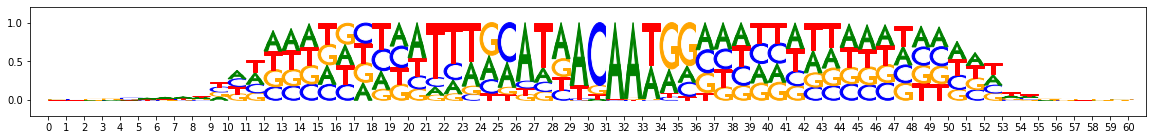

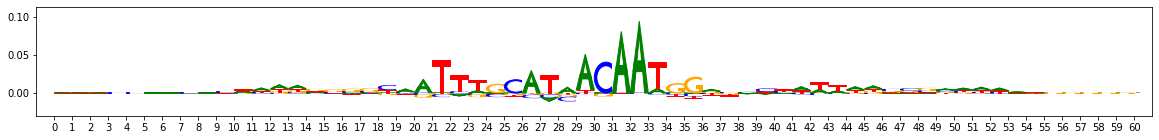

rev


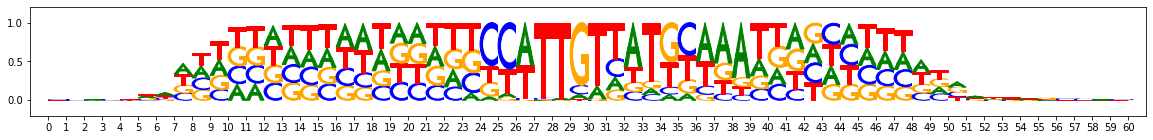

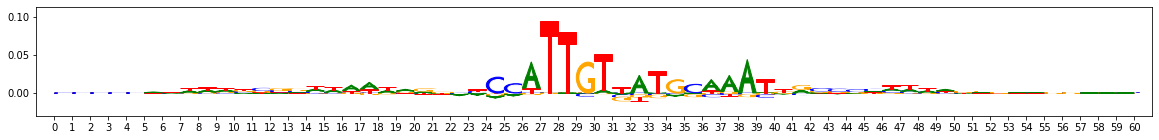

remapped WITHOUT competition - num seqlets 1535


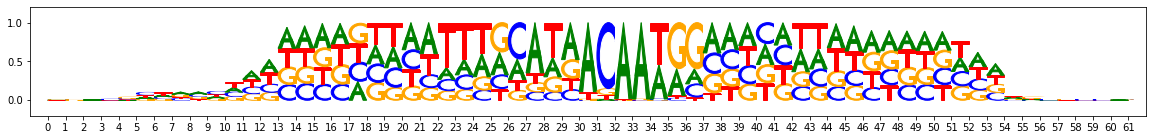

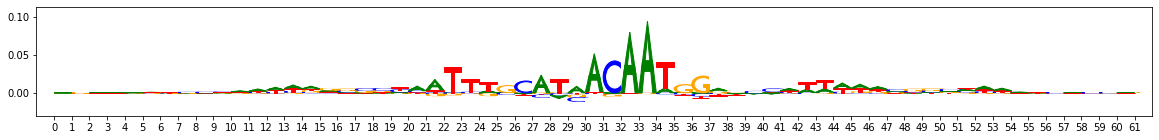

remapped WITH competition - num seqlets 556


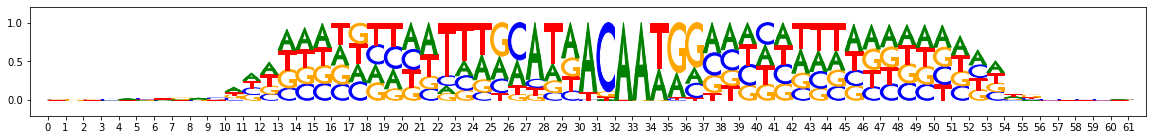

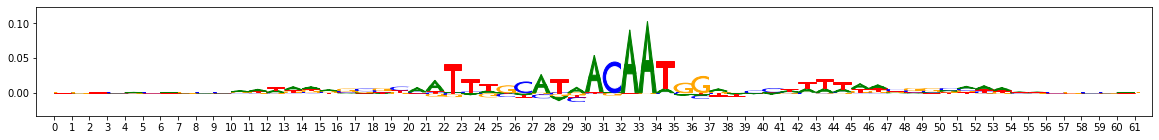

cluster idx: 2
original - num seqlets 636
fwd


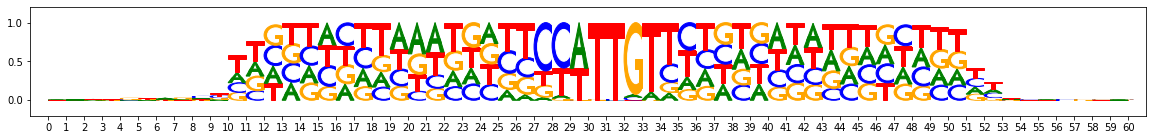

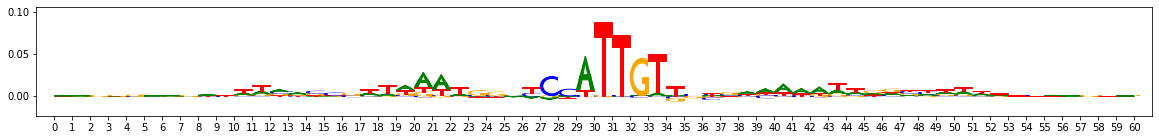

rev


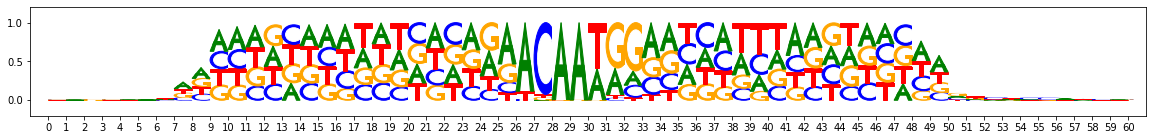

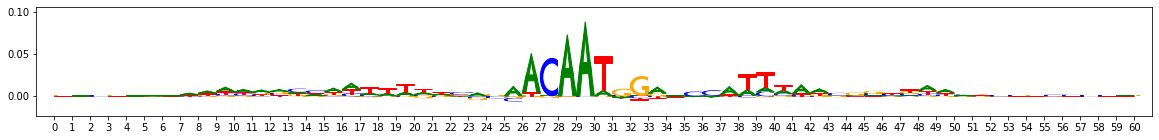

remapped WITHOUT competition - num seqlets 1536


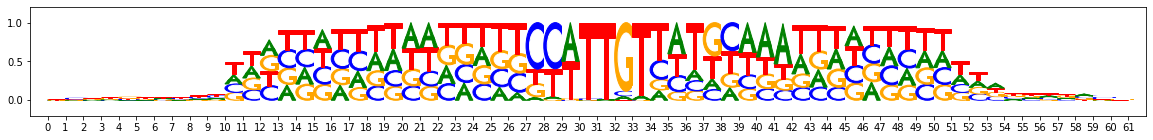

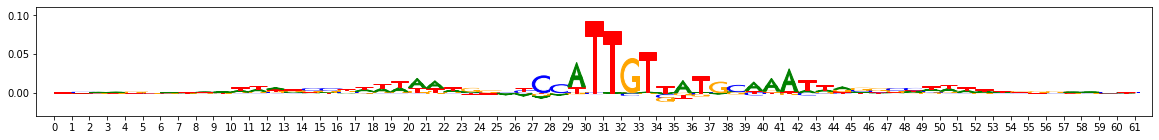

remapped WITH competition - num seqlets 714


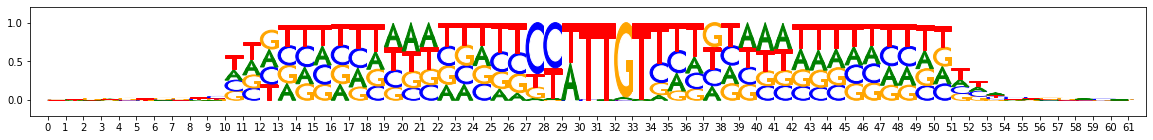

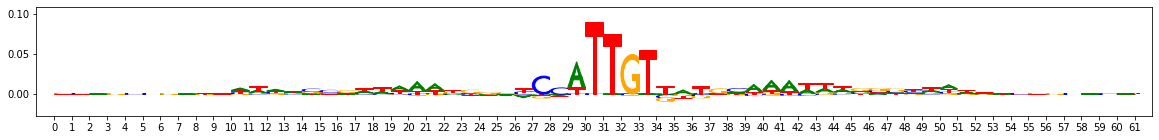

cluster idx: 3
original - num seqlets 488
fwd


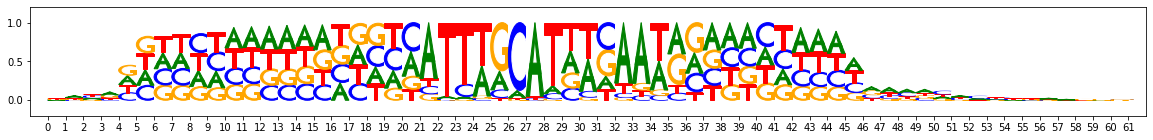

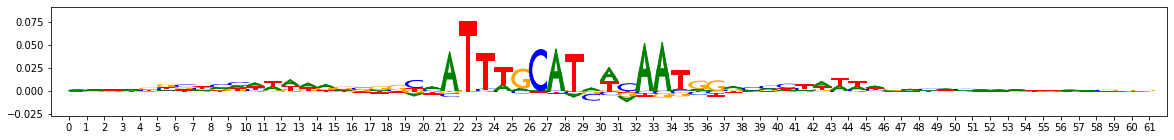

rev


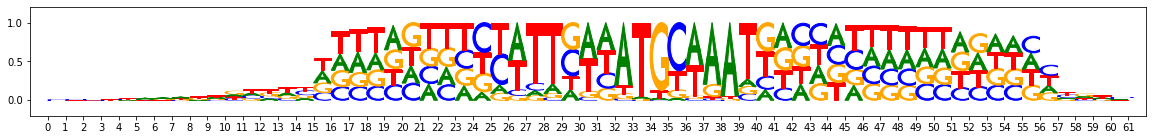

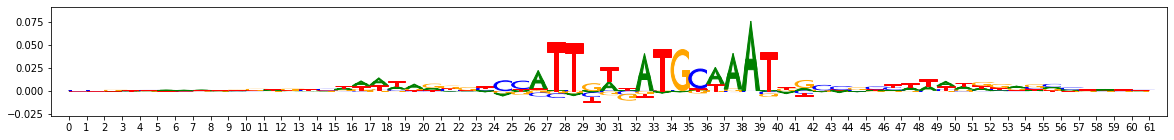

remapped WITHOUT competition - num seqlets 887


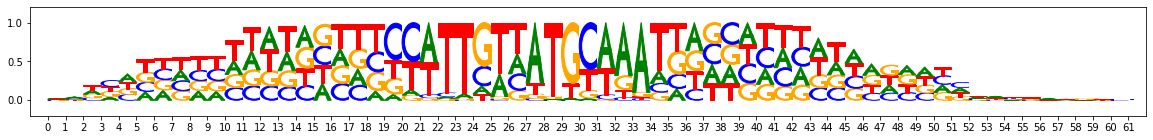

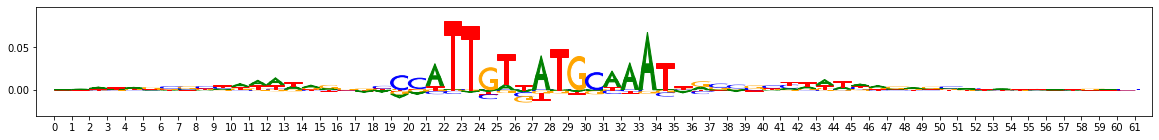

remapped WITH competition - num seqlets 522


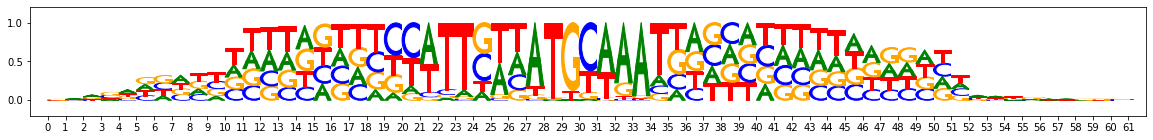

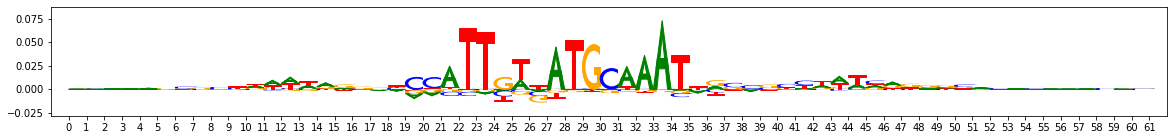

cluster idx: 4
original - num seqlets 247
fwd


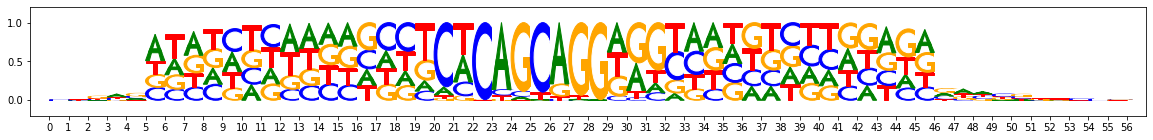

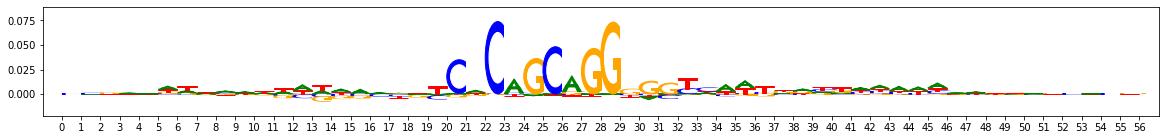

rev


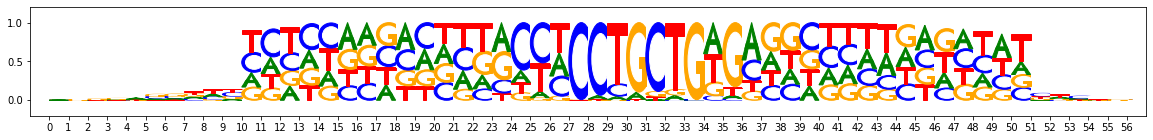

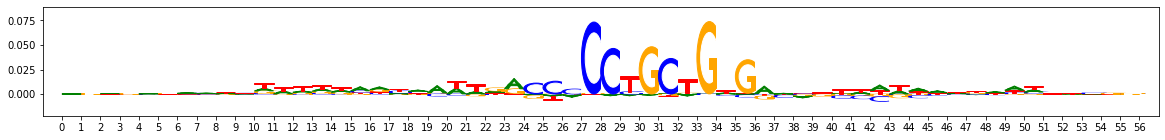

remapped WITHOUT competition - num seqlets 290


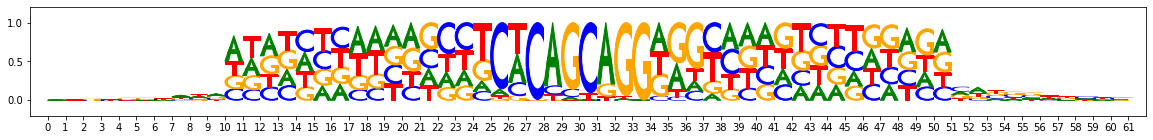

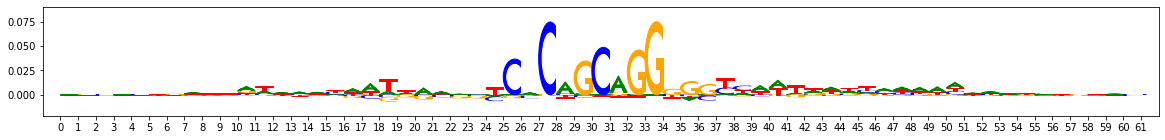

remapped WITH competition - num seqlets 266


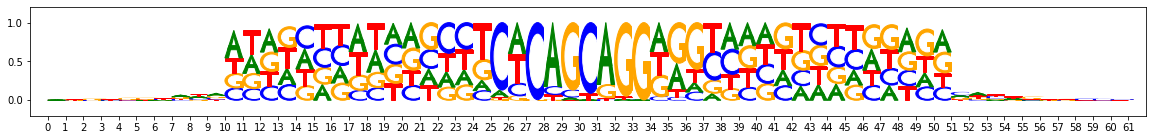

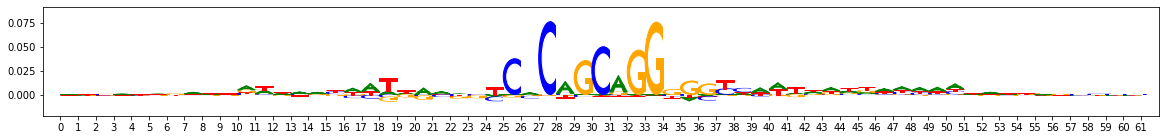

cluster idx: 5
original - num seqlets 203
fwd


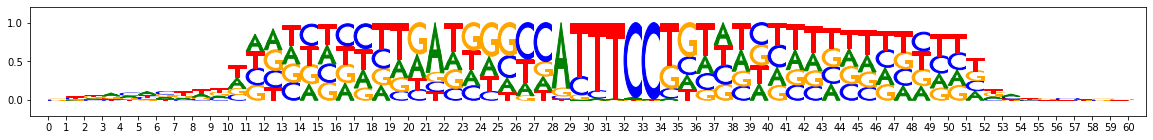

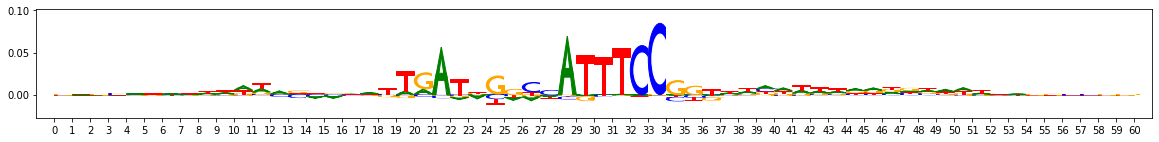

rev


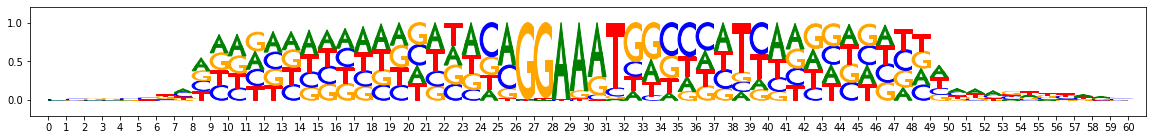

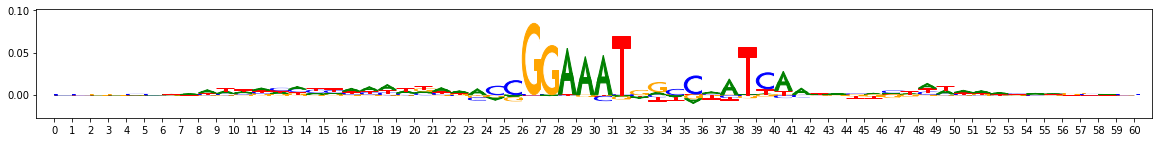

remapped WITHOUT competition - num seqlets 217


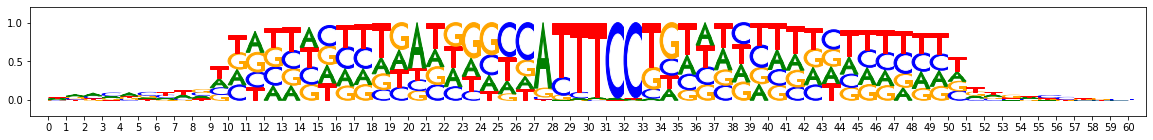

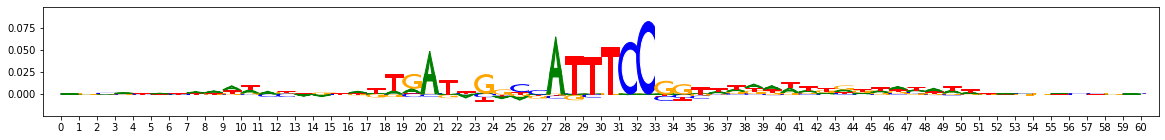

remapped WITH competition - num seqlets 187


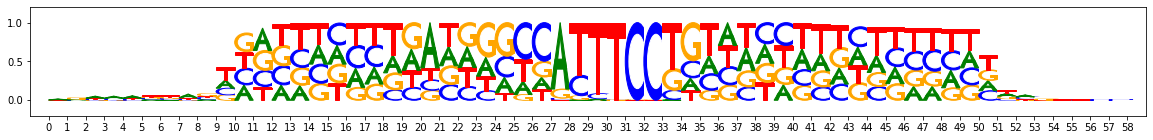

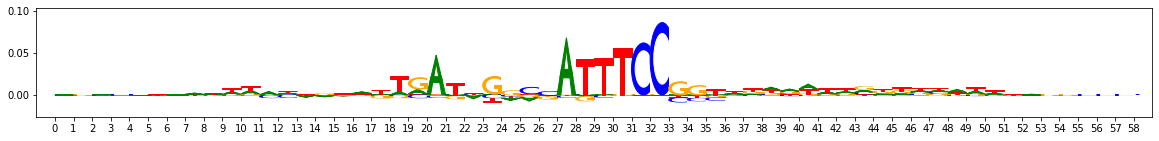

cluster idx: 6
original - num seqlets 184
fwd


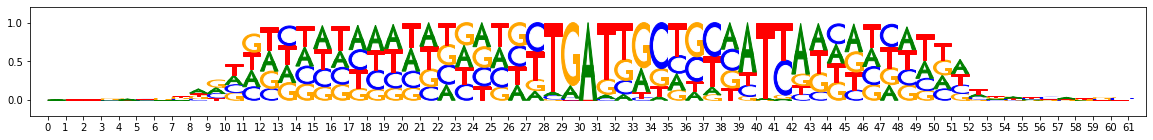

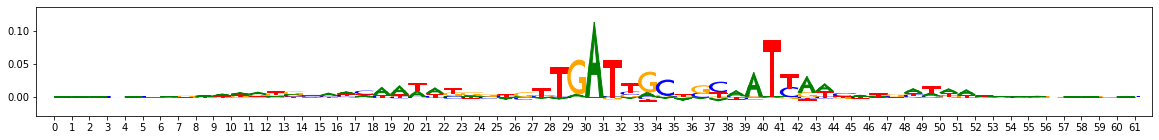

rev


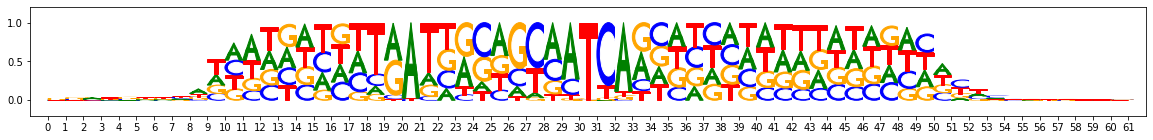

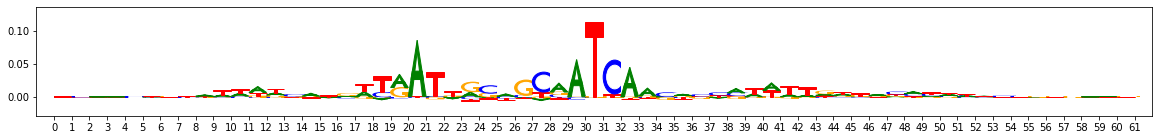

remapped WITHOUT competition - num seqlets 307


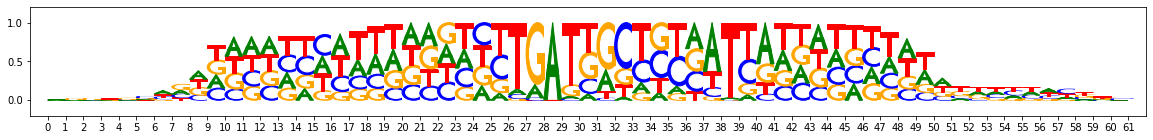

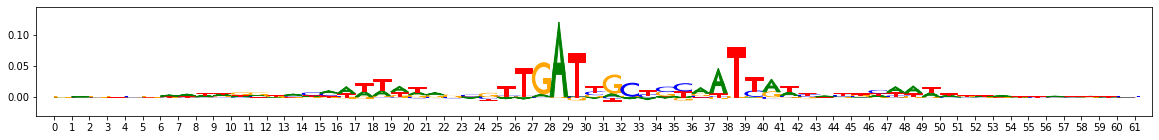

remapped WITH competition - num seqlets 124


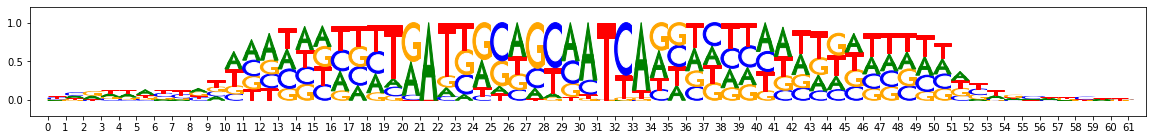

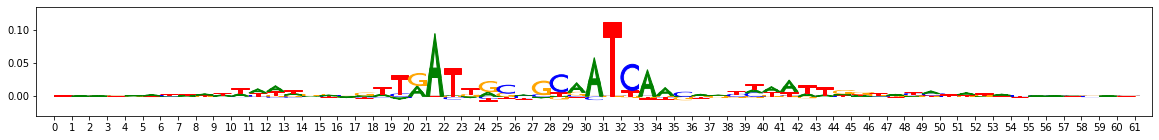

cluster idx: 7
original - num seqlets 96
fwd


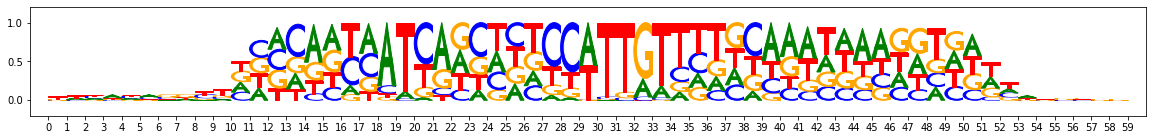

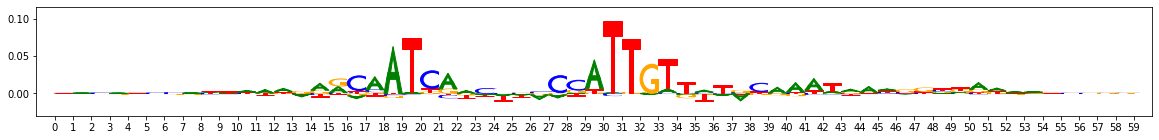

rev


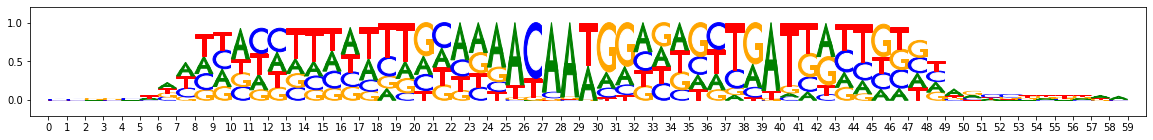

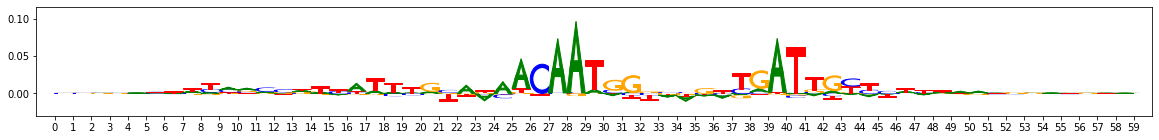

remapped WITHOUT competition - num seqlets 384


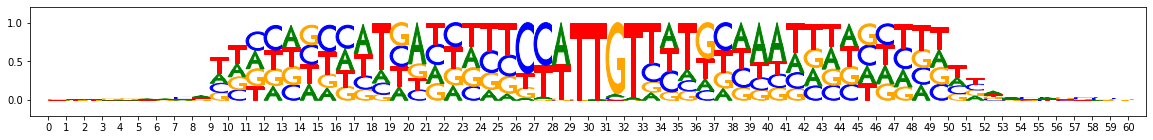

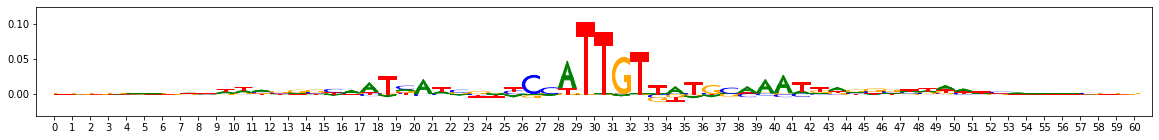

remapped WITH competition - num seqlets 72


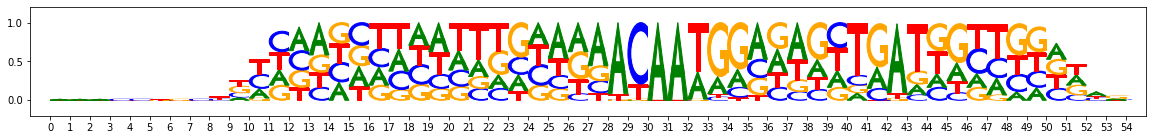

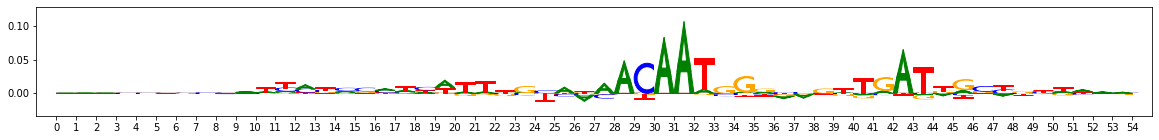

cluster idx: 8
original - num seqlets 43
fwd


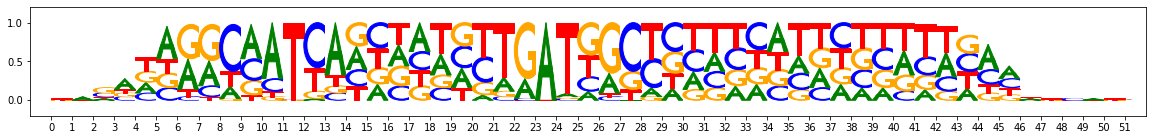

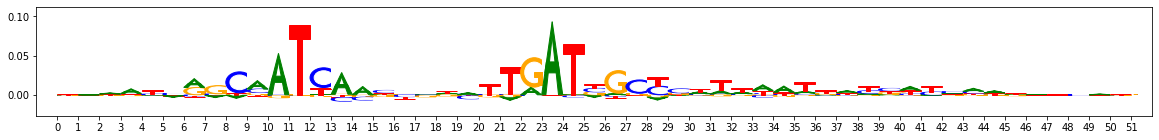

rev


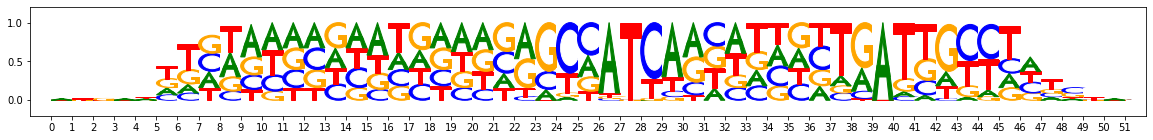

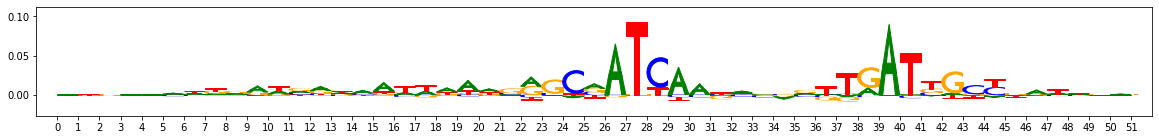

remapped WITHOUT competition - num seqlets 85


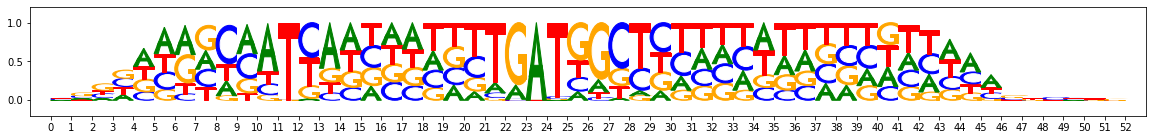

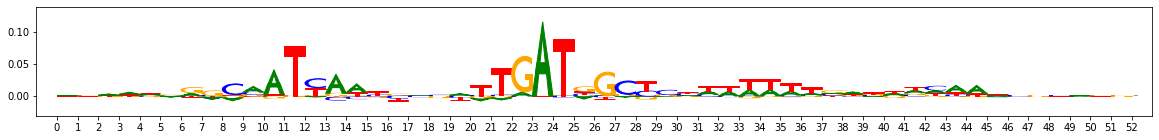

remapped WITH competition - num seqlets 27


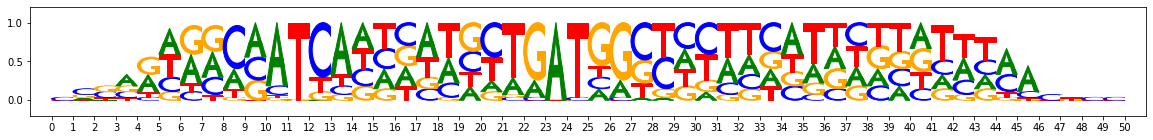

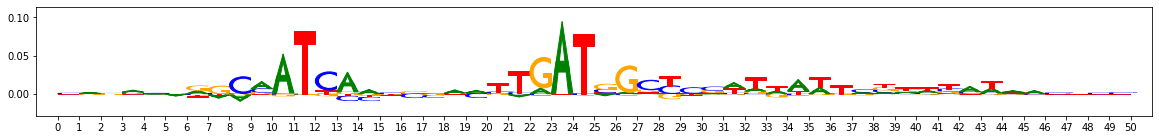

cluster idx: 9
original - num seqlets 33
fwd


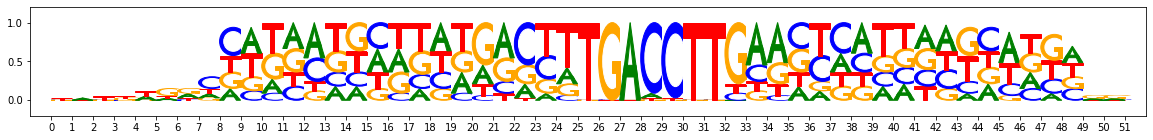

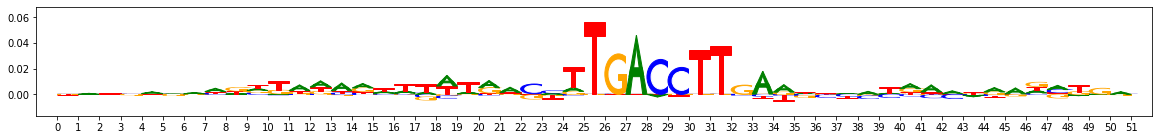

rev


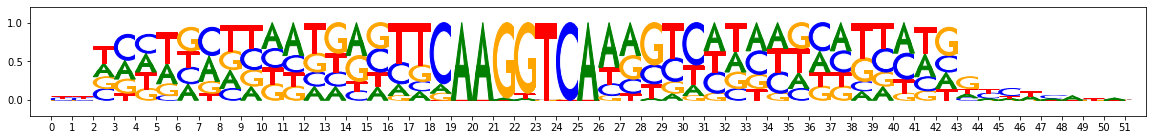

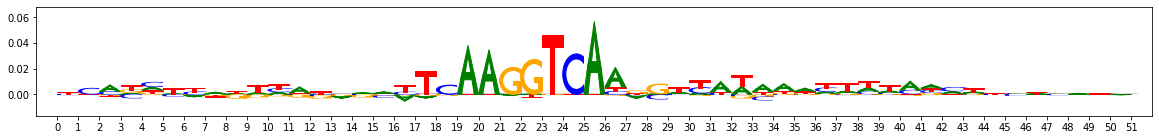

remapped WITHOUT competition - num seqlets 58


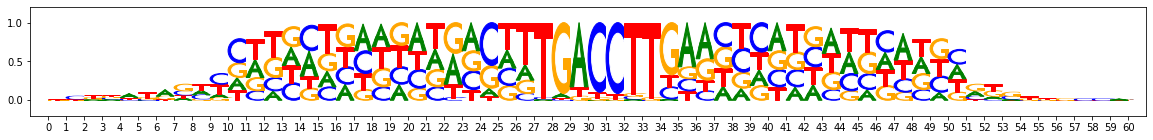

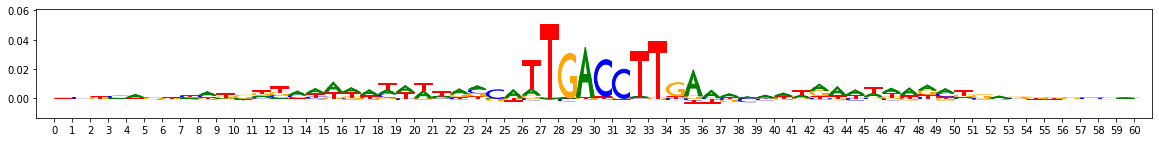

remapped WITH competition - num seqlets 46


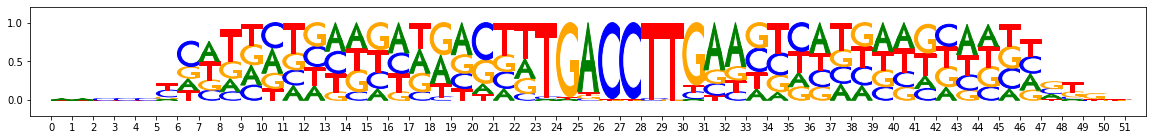

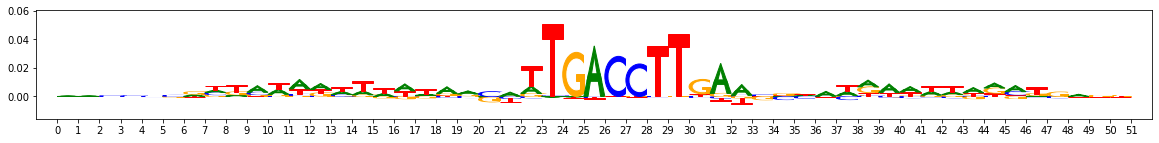

cluster idx: 10
original - num seqlets 32
fwd


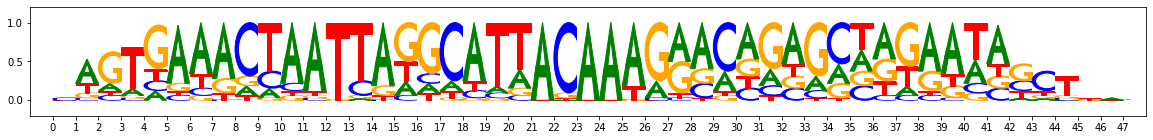

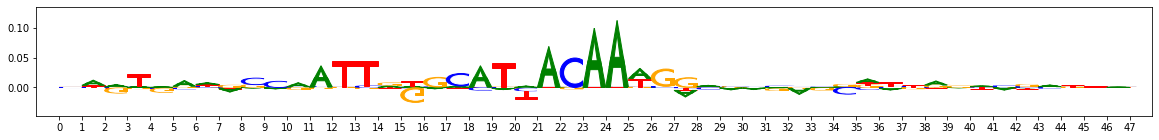

rev


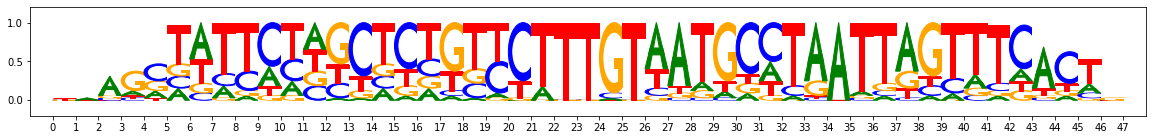

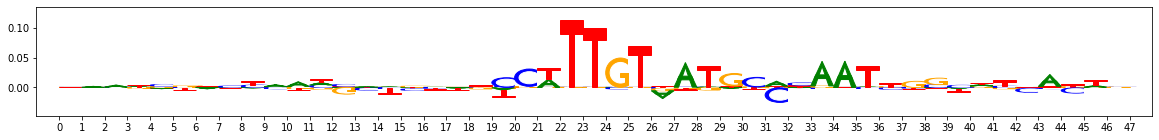

remapped WITHOUT competition - num seqlets 128


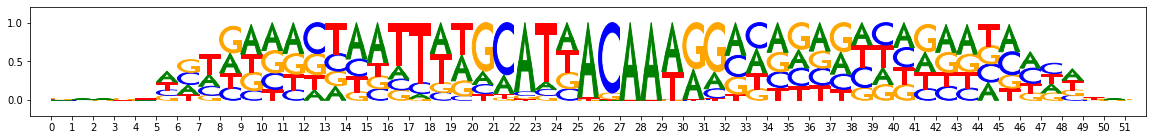

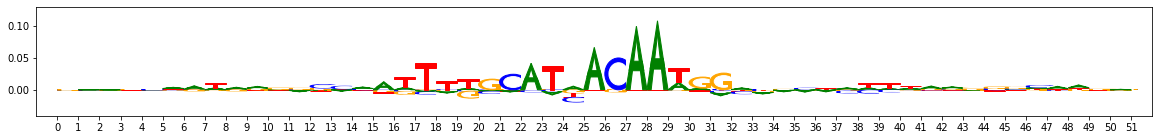

remapped WITH competition - num seqlets 9


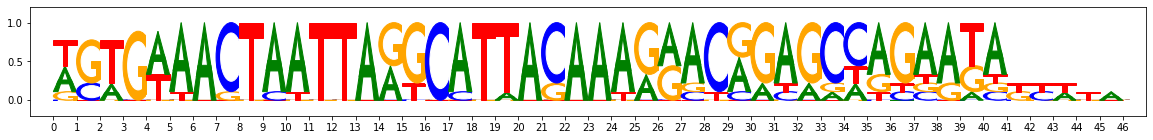

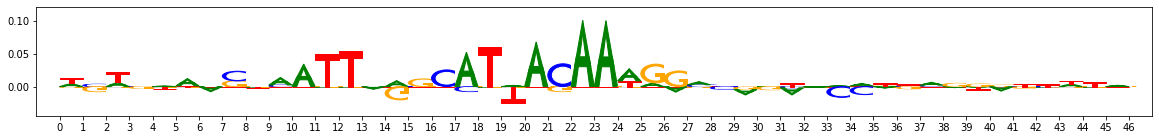

In [122]:
import modisco.core
reload(modisco.core)

for idx in cluster_to_weighted_exemplars:
    print("cluster idx:",idx)
    aggregated_seqlet = clusteridx_to_aggregated_seqlet[idx]
    print("original - num seqlets", len(aggregated_seqlet.seqlets))
    print("fwd")
    viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
    viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
    print("rev")
    viz_sequence.plot_weights(aggregated_seqlet["onehot"].rev)
    viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].rev)

    #WITHOUT competition
    exemplarbased_nocompetition_withinclustermask = exemplarbased_seqlettoclusterscore[:,idx] > -1
    exemplarbased_nocompetition_aggseqlet, _ = get_aggregated_seqlet(
            seqlets=seqlets_subsample, in_cluster_mask=exemplarbased_nocompetition_withinclustermask,
            onehot_trackname="onehot", hyp_trackname="hypcontrib_scores",
                flanklen=flanksize, min_overlap_frac=min_overlap_frac,
                pair_sim_metric=pair_sim_metric)
    print("remapped WITHOUT competition - num seqlets", len(exemplarbased_nocompetition_aggseqlet.seqlets))
    viz_sequence.plot_weights(exemplarbased_nocompetition_aggseqlet["onehot"].fwd)
    viz_sequence.plot_weights(exemplarbased_nocompetition_aggseqlet["contrib_scores"].fwd)

    #WITH competition
    exemplarbased_withinclustermask = exemplarbased_clusterassignment==idx
    if (sum(exemplarbased_withinclustermask)>0):
        exemplarbased_aggseqlet, _ = get_aggregated_seqlet(
                seqlets=seqlets_subsample, in_cluster_mask=exemplarbased_withinclustermask,
                onehot_trackname="onehot", hyp_trackname="hypcontrib_scores",
                flanklen=flanksize, min_overlap_frac=min_overlap_frac,
                pair_sim_metric=pair_sim_metric)
        print("remapped WITH competition - num seqlets", len(exemplarbased_aggseqlet.seqlets))
        viz_sequence.plot_weights(exemplarbased_aggseqlet["onehot"].fwd)
        viz_sequence.plot_weights(exemplarbased_aggseqlet["contrib_scores"].fwd)
    else:
        print("No seqlets in competitive remapping")

debugging...

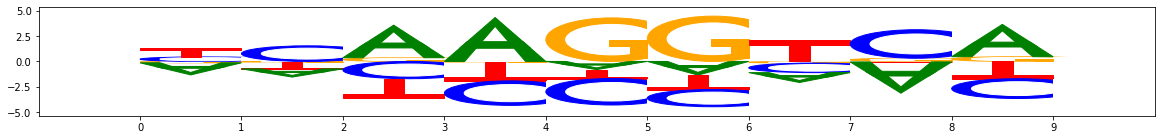

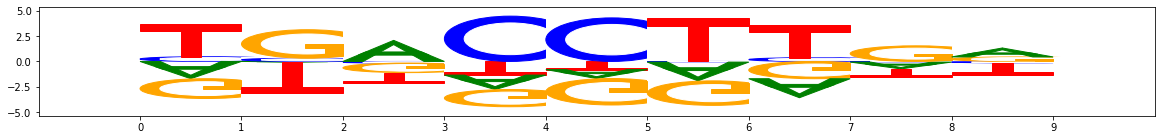

In [123]:
import numpy as np
from modisco.visualization import viz_sequence
#from hocomoco
esrrb_pwm = np.array([[-1.44, 0.192, -0.389, 0.628],
                      [-1.299, 1.044, -0.556, -1.165],
                      [1.317, -3.59, -1.522, -3.764],
                      [1.371, -5.368, -3.02, -4.805],
                      [-3.717, -5.521, 1.374, -3.793],
                      [-4.428, -4.778, 1.378, -4.504],
                      [-1.85, -1.816, -1.035, 1.201],
                      [-4.632, 1.253, -1.243, -1.607],
                      [1.31, -3.823, -1.406, -3.574]])
viz_sequence.plot_weights(esrrb_pwm - np.mean(esrrb_pwm, axis=-1)[:,None])
viz_sequence.plot_weights((esrrb_pwm - np.mean(esrrb_pwm, axis=-1)[:,None])[::-1,::-1])

In [124]:
import modisco
import modisco.util
reload(modisco.util)
#scan the sequences for hits
esrrb_cosine_sim, esrrb_imp_score = modisco.util.get_hCWM_scores(
        imp_scores=np.array([x["contrib_scores"].corefwd for x in seqlets_subsample]),
        onehot_seq=np.array([x["onehot"].corefwd for x in seqlets_subsample]),
        weightmat=esrrb_pwm)
#esrrb_pwm_scores = #TODO: do a fwd and rev pwm score

"""subsample_seqlet_onehots_concat = 
esrrb_scan_scores = modisco.util.get_max_pwm_score_in_sequences(
                        onehot_seq=subsample_seqlet_onehots_concat,
                        weightmat=esrrb_pwm)
#sort seqlets in descending order of high scores
esrrb_argsort_scores = np.argsort(-esrrb_scan_scores)
for argsort_idx in esrrb_argsort_scores:
    print(argsort_idx, esrrb_scan_scores[argsort_idx])
    viz_sequence.plot_weights(seqlets_subsample[argsort_idx]["contrib_scores"].corefwd)
    viz_sequence.plot_weights(seqlets_subsample[argsort_idx]["meannorm_hypcontrib_scores"].corefwd
                              *seqlets_subsample[argsort_idx]["onehot"].corefwd)"""

'subsample_seqlet_onehots_concat = \nesrrb_scan_scores = modisco.util.get_max_pwm_score_in_sequences(\n                        onehot_seq=subsample_seqlet_onehots_concat,\n                        weightmat=esrrb_pwm)\n#sort seqlets in descending order of high scores\nesrrb_argsort_scores = np.argsort(-esrrb_scan_scores)\nfor argsort_idx in esrrb_argsort_scores:\n    print(argsort_idx, esrrb_scan_scores[argsort_idx])\n    viz_sequence.plot_weights(seqlets_subsample[argsort_idx]["contrib_scores"].corefwd)\n    viz_sequence.plot_weights(seqlets_subsample[argsort_idx]["meannorm_hypcontrib_scores"].corefwd\n                              *seqlets_subsample[argsort_idx]["onehot"].corefwd)'

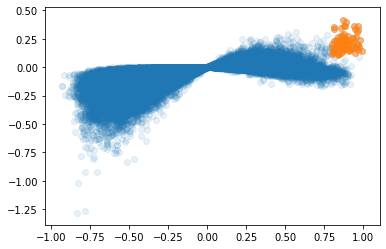

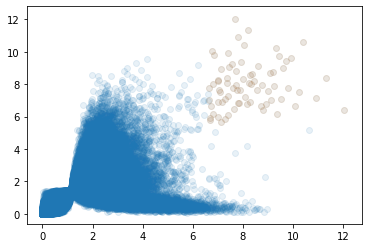

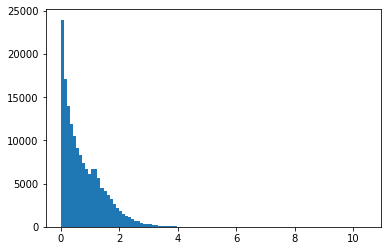

number of central esrrb hits: 41
seqlet 139
orig clustering (size filtered) 3
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9760316583673199 0.24089203603329412


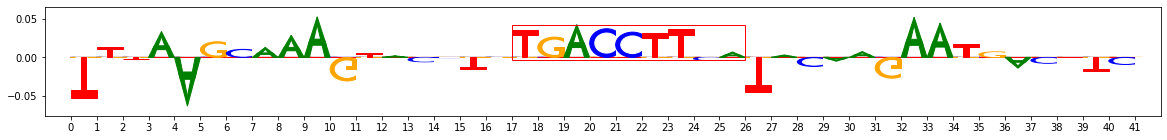

seqlet 246
orig clustering (size filtered) -1
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8313819518902686 0.19977228692627133


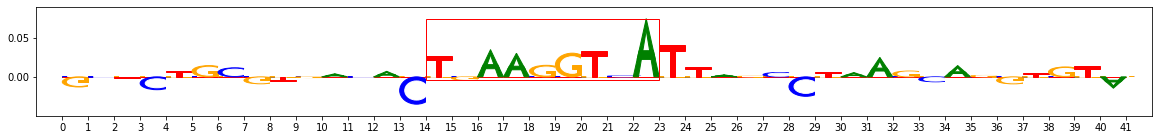

seqlet 509
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8876855275416418 0.24873025607828775


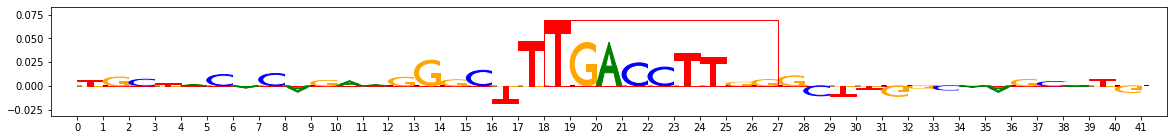

seqlet 626
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8555176267972724 0.23896583651456194


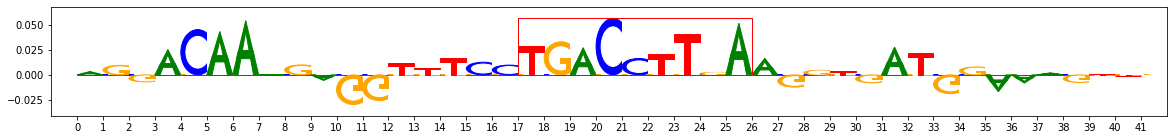

seqlet 766
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8289500494439506 0.23244424601241256


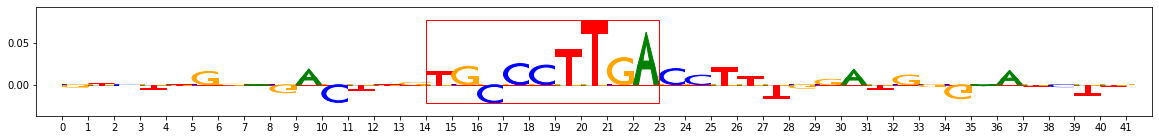

seqlet 865
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8907063586016832 0.22844601178827503


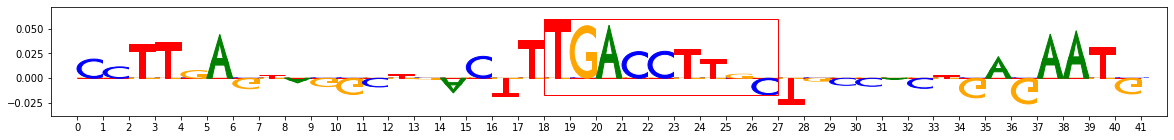

seqlet 982
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8869108216600562 0.22978375678458687


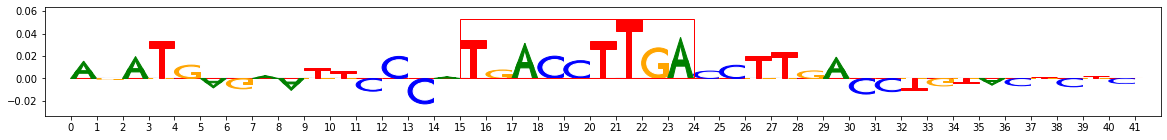

seqlet 982
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.845939060537932 0.17355399797335305


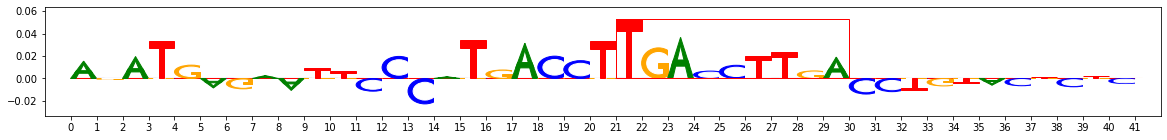

seqlet 1141
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8960175424148702 0.23252923359624528


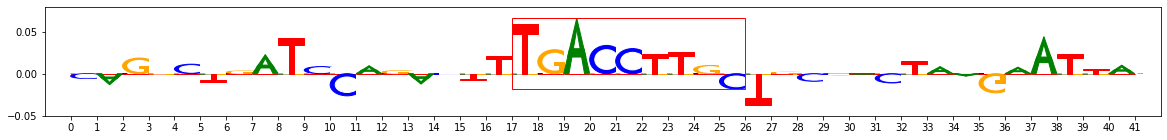

seqlet 1250
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8833090382602461 0.17830703576825077


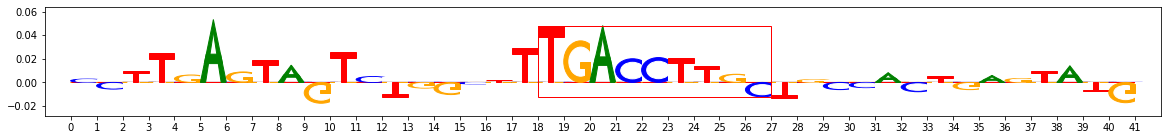

seqlet 1443
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8778037610123303 0.20147278064501123


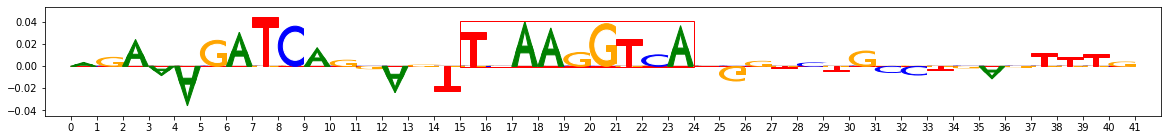

seqlet 1453
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) []
exemplarbased_clusterassignment (with competition) -1.0
0.8677615084282947 0.41287009640115113


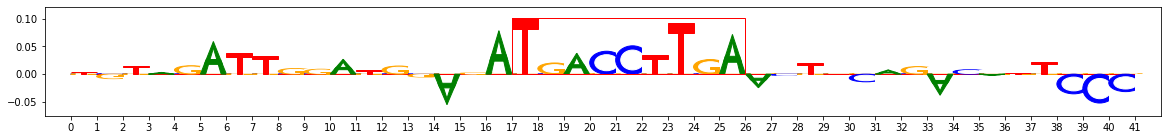

seqlet 1584
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8102069314334596 0.3569231655771124


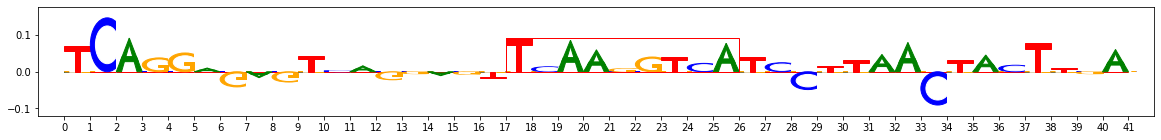

seqlet 1646
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8321554707448962 0.19402710891551944


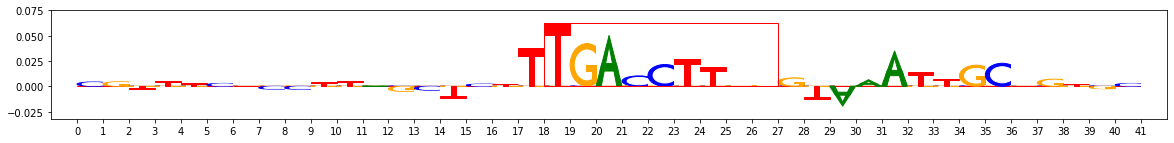

seqlet 1659
orig clustering (size filtered) 1
exemplarbased_clusterassignemnt (no competition) [1 2 9]
exemplarbased_clusterassignment (with competition) 9.0
0.8865678835942165 0.39818100893449454


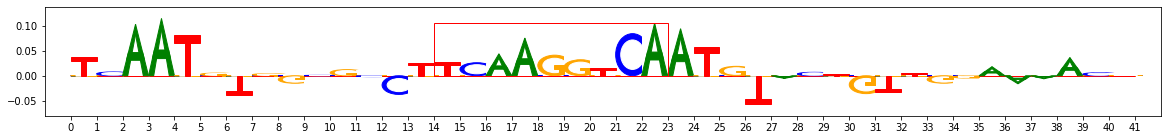

seqlet 1914
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8133654954872497 0.2265053632841232


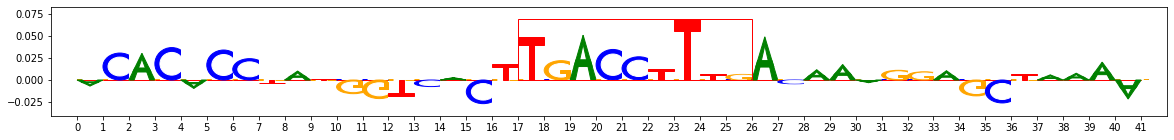

seqlet 2122
orig clustering (size filtered) 5
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9696945133217544 0.1744457218594531


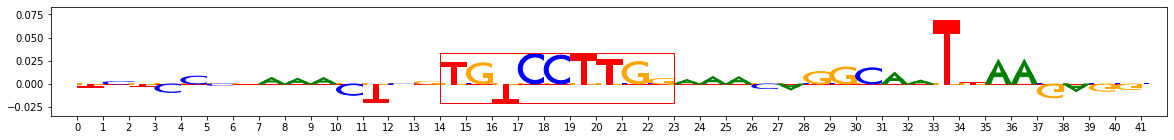

seqlet 2170
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8666828100323862 0.20344999504147346


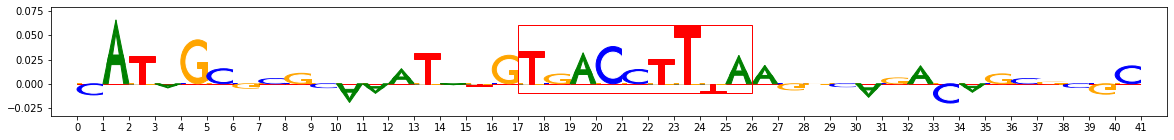

seqlet 2217
orig clustering (size filtered) -1
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.873361548536842 0.2236232793251266


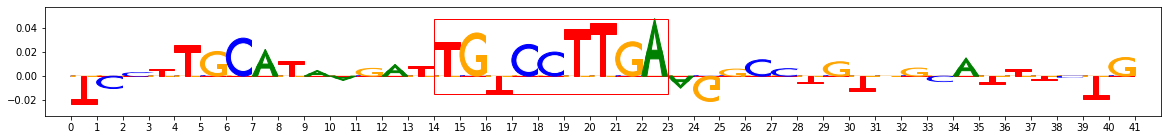

seqlet 2359
orig clustering (size filtered) 1
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9343017625491524 0.17049192159607596


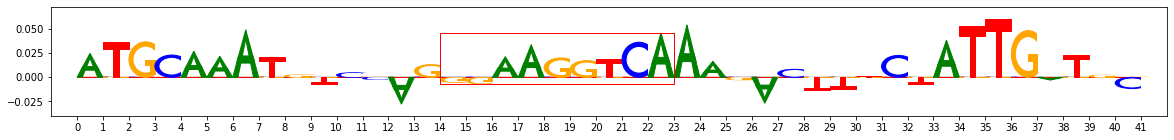

seqlet 2421
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8912834316846735 0.2502240838963524


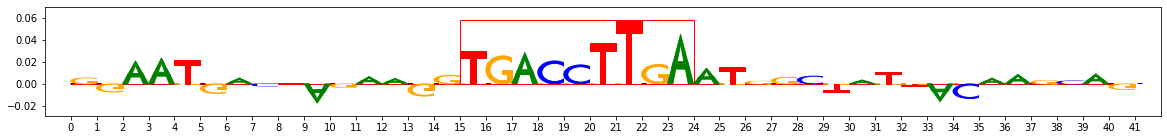

seqlet 2544
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8571802462825344 0.27502427647779976


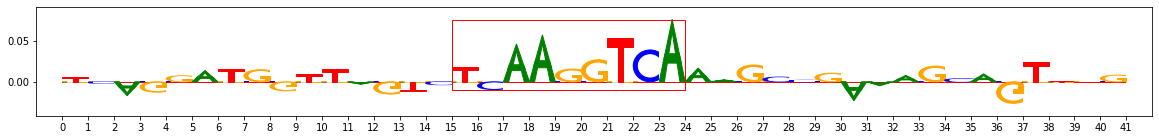

seqlet 2800
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.936318543486119 0.21796939641157315


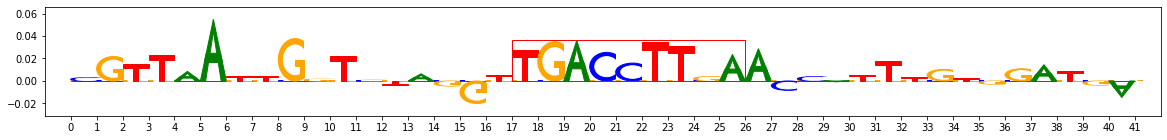

seqlet 2988
orig clustering (size filtered) -1
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9331412342214017 0.2524208260121939


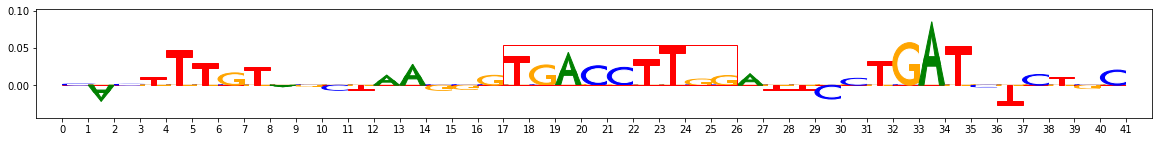

seqlet 2989
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8558186908761968 0.34625732559469335


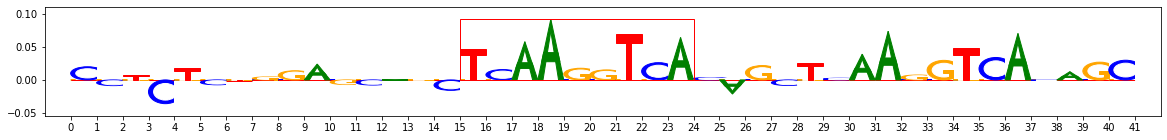

seqlet 3159
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8554183061543994 0.23163929312450796


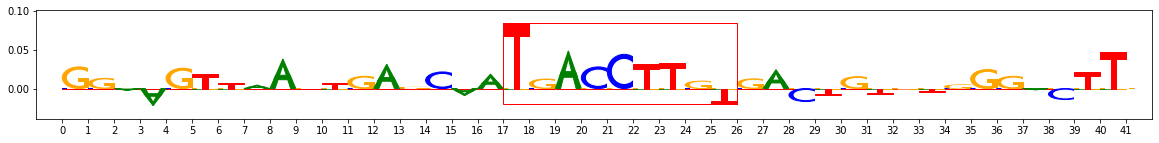

seqlet 3331
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8786376717967597 0.2926682827306626


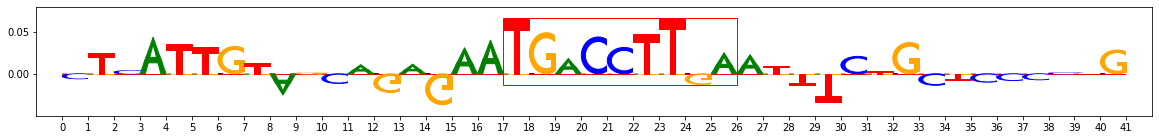

seqlet 3443
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8813981514828346 0.23586542871673266


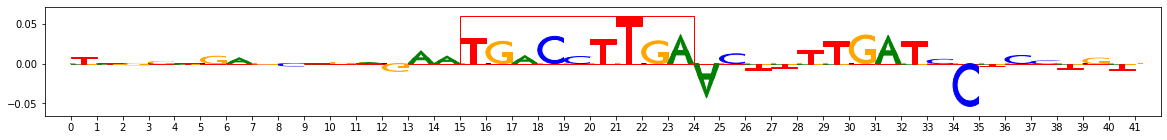

seqlet 3472
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8147716161308862 0.3332130671220513


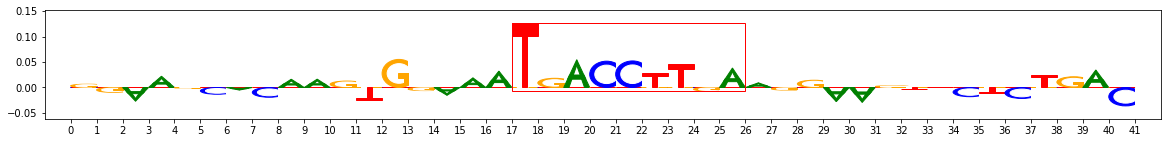

seqlet 3552
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [0 9]
exemplarbased_clusterassignment (with competition) 9.0
0.96162966673921 0.20594389457187953


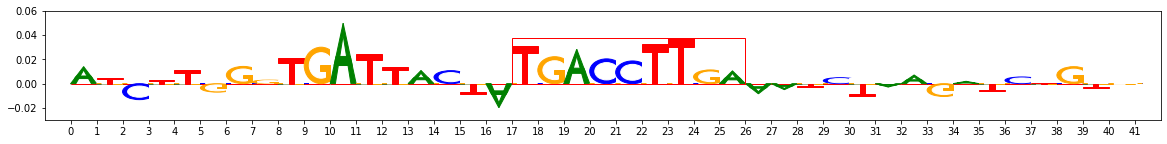

seqlet 3556
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.8561653476827739 0.18176442858978276


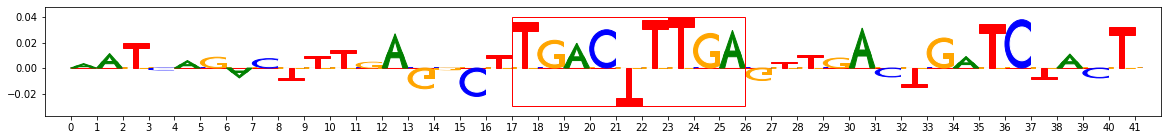

seqlet 3754
orig clustering (size filtered) -1
exemplarbased_clusterassignemnt (no competition) []
exemplarbased_clusterassignment (with competition) -1.0
0.8745844970409352 0.2595761465441694


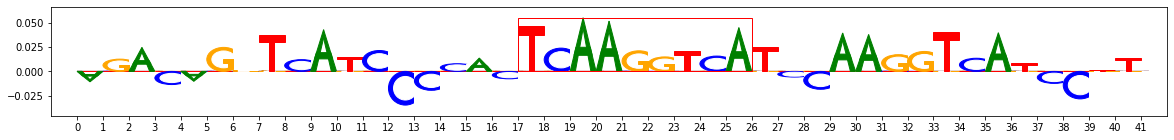

seqlet 3792
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9365696510890148 0.35776932692661


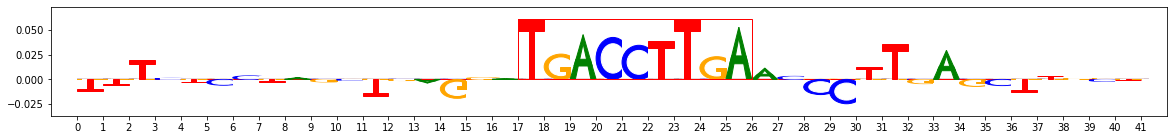

seqlet 3952
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9453636604934801 0.3319341116741564


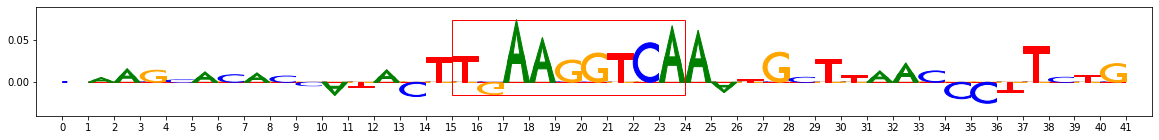

seqlet 3965
orig clustering (size filtered) 0
exemplarbased_clusterassignemnt (no competition) [0]
exemplarbased_clusterassignment (with competition) 0.0
0.8359461366787805 0.16393222341415736


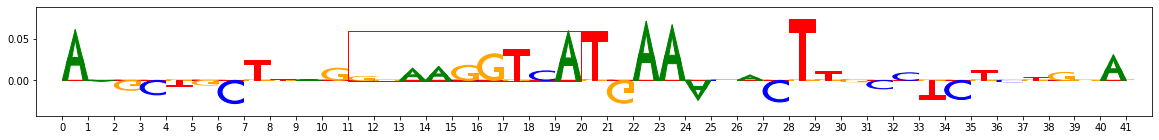

seqlet 4266
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9344650447514651 0.25753278875483365


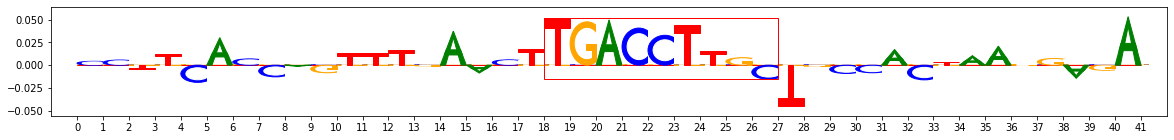

seqlet 4320
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9021694522333819 0.27696285930917036


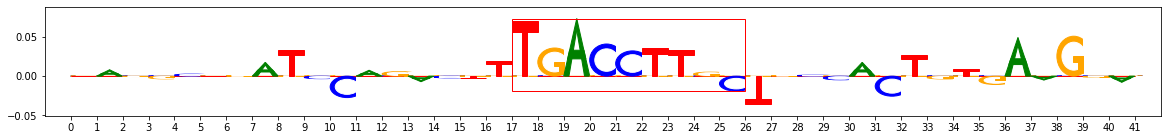

seqlet 4649
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [0 9]
exemplarbased_clusterassignment (with competition) 9.0
0.9282358183170072 0.19514018777775202


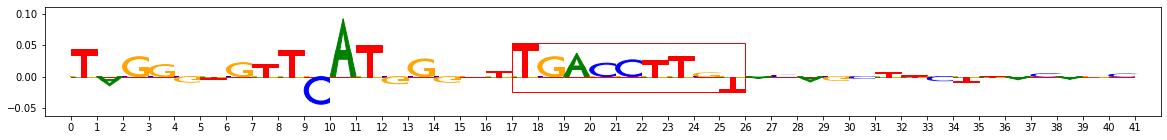

seqlet 4753
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9553404674891235 0.26690771154178594


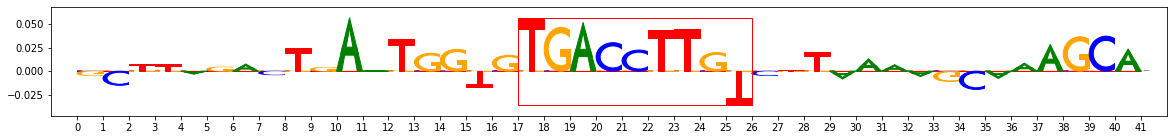

seqlet 4787
orig clustering (size filtered) 9
exemplarbased_clusterassignemnt (no competition) [9]
exemplarbased_clusterassignment (with competition) 9.0
0.9678138855773188 0.36555547734048466


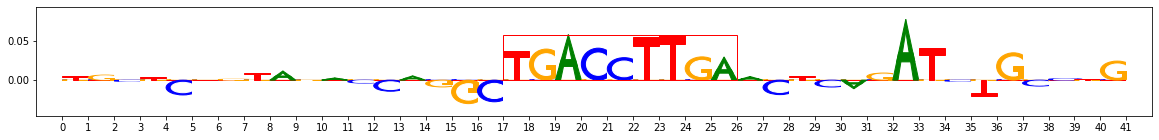

seqlet 4876
orig clustering (size filtered) -1
exemplarbased_clusterassignemnt (no competition) []
exemplarbased_clusterassignment (with competition) -1.0
0.8354956801034904 0.26665855626521556


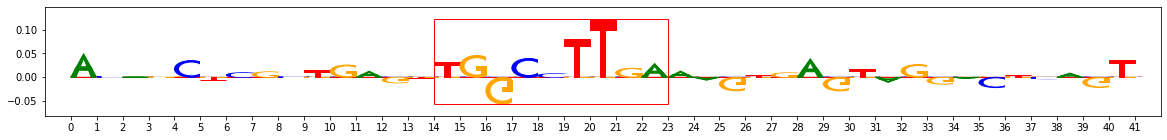

In [125]:
import modisco.util
reload(modisco.util)

bothpos = (esrrb_imp_score > 0)*(esrrb_cosine_sim > 0)
impcosineprod = np.abs(esrrb_imp_score*esrrb_cosine_sim)*((2*bothpos - 1))

esrrb_hits = (esrrb_cosine_sim > 0.8)*(impcosineprod > 0.1)
plt.scatter(esrrb_cosine_sim, impcosineprod, alpha=0.1)
plt.scatter(esrrb_cosine_sim[esrrb_hits], impcosineprod[esrrb_hits], alpha=0.5)
plt.show()

#also do a percentile--percentile scatterplot
cosine_sim_percentiles = -np.log(1-modisco.util.percentile_transform(esrrb_cosine_sim.ravel()))
impcosineprod_percentiles = -np.log(1-modisco.util.percentile_transform(impcosineprod.ravel()))
plt.scatter(cosine_sim_percentiles, impcosineprod_percentiles, alpha=0.1)
plt.scatter(cosine_sim_percentiles[esrrb_hits.ravel()], impcosineprod_percentiles[esrrb_hits.ravel()], alpha=0.1)
#plt.xlim(0.99, 1.0)
#plt.ylim(0.99, 1.0)
plt.show()
min_percentiles = np.minimum(cosine_sim_percentiles, impcosineprod_percentiles)
plt.hist(min_percentiles, bins=100)
plt.show()


#central = centrally-located in seqlet (thus being more likely to be the dominant pattern)
central_esrrb_hitcoords = [(hit_seqletnum, hit_pos) for (hit_seqletnum, hit_pos)
                            in zip(*np.nonzero(esrrb_hits)) if (hit_pos > 9 and hit_pos < 23)]
print("number of central esrrb hits:", len(central_esrrb_hitcoords))
seqlets_with_esrrb_hit_in_center = []
for hit_seqletnum, hit_pos in central_esrrb_hitcoords:
    if hit_seqletnum not in seqlets_with_esrrb_hit_in_center:
        seqlets_with_esrrb_hit_in_center.append(hit_seqletnum)
    print("seqlet", hit_seqletnum)
    print("orig clustering (size filtered)", refined_clustering[hit_seqletnum])
    #"refined just by size", refinedbysize_clustering[hit_seqletnum]
    print("exemplarbased_clusterassignemnt (no competition)",
           np.nonzero(exemplarbased_seqlettoclusterscore[hit_seqletnum] > -1)[0])
    print("exemplarbased_clusterassignment (with competition)", exemplarbased_clusterassignment[hit_seqletnum])
    print(esrrb_cosine_sim[hit_seqletnum, hit_pos], impcosineprod[hit_seqletnum, hit_pos])
    viz_sequence.plot_weights(seqlets_subsample[hit_seqletnum]["contrib_scores"].corefwd,
                              highlight={'red':[(hit_pos, hit_pos+len(esrrb_pwm))] })

on cluster 9
Cluster size: 33
seqlet_idx 271 max essrb cosine sim 0.5692384845977354


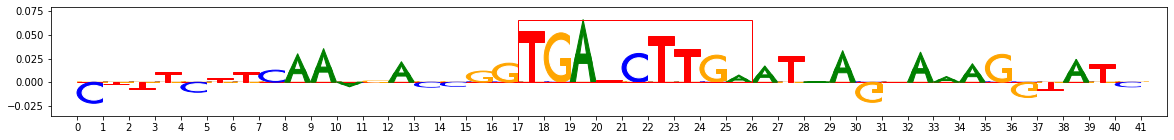

seqlet_idx 509 max essrb cosine sim 0.8876855275416418


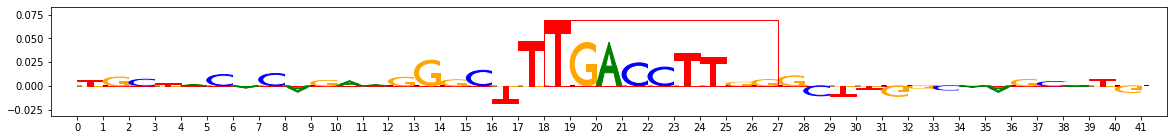

seqlet_idx 626 max essrb cosine sim 0.8555176267972724


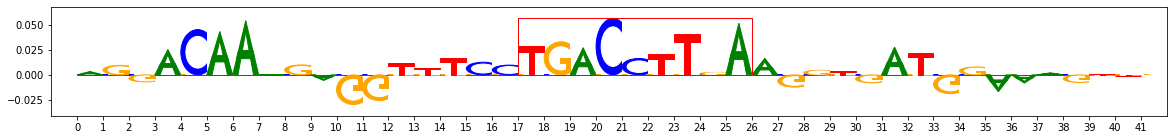

seqlet_idx 766 max essrb cosine sim 0.8289500494439506


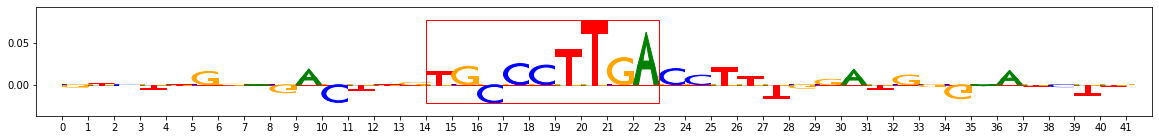

seqlet_idx 865 max essrb cosine sim 0.8907063586016832


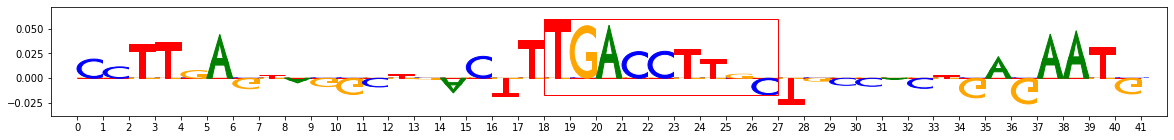

seqlet_idx 982 max essrb cosine sim 0.8869108216600562


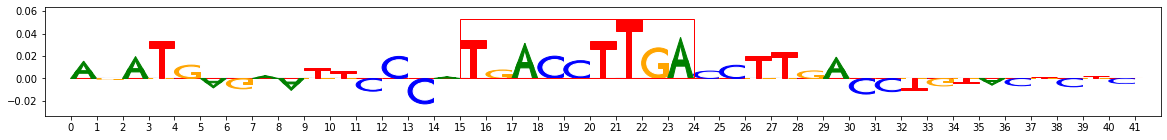

seqlet_idx 1141 max essrb cosine sim 0.8960175424148702


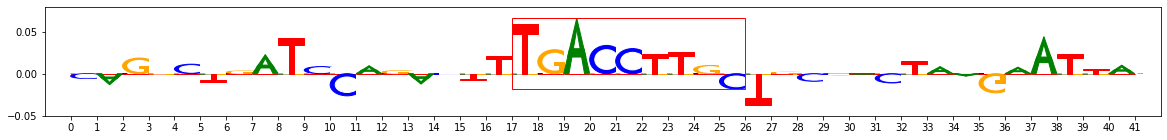

seqlet_idx 1250 max essrb cosine sim 0.8833090382602461


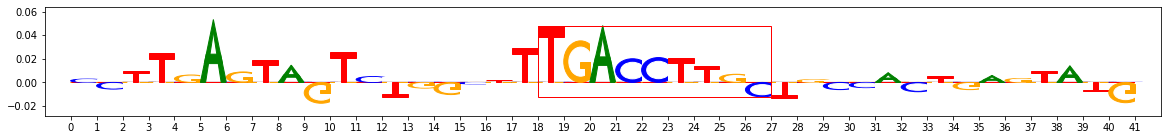

seqlet_idx 1443 max essrb cosine sim 0.8778037610123303


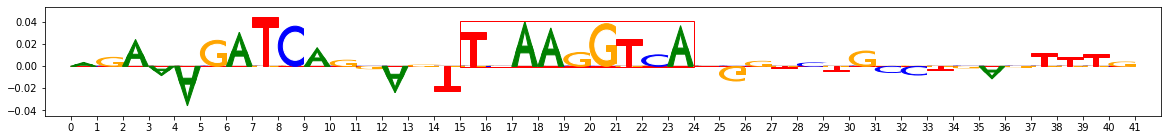

seqlet_idx 1453 max essrb cosine sim 0.8677615084282947


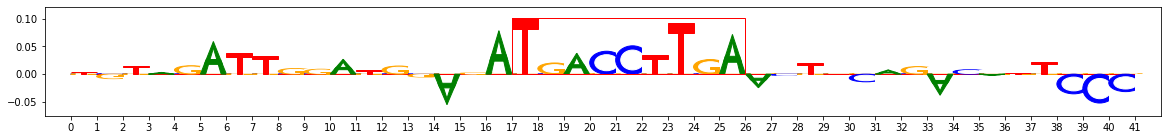

seqlet_idx 1584 max essrb cosine sim 0.8102069314334596


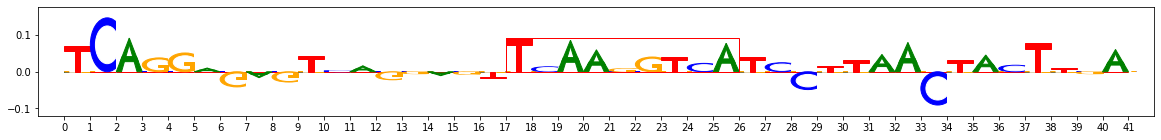

seqlet_idx 1646 max essrb cosine sim 0.8321554707448962


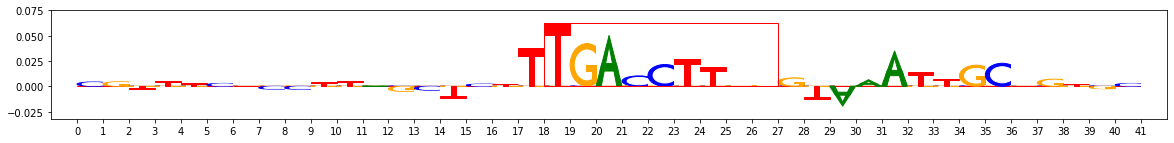

seqlet_idx 1914 max essrb cosine sim 0.8133654954872497


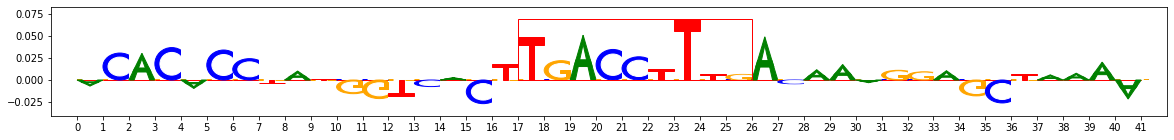

seqlet_idx 2170 max essrb cosine sim 0.8666828100323862


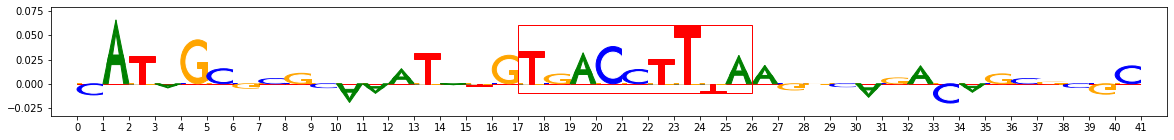

seqlet_idx 2421 max essrb cosine sim 0.8912834316846735


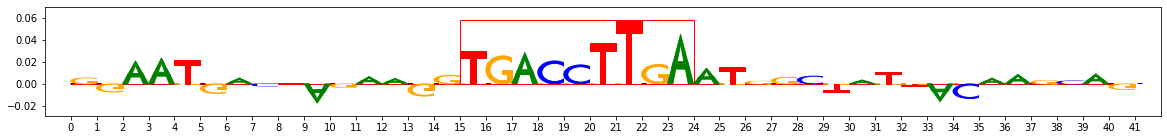

seqlet_idx 2544 max essrb cosine sim 0.8571802462825344


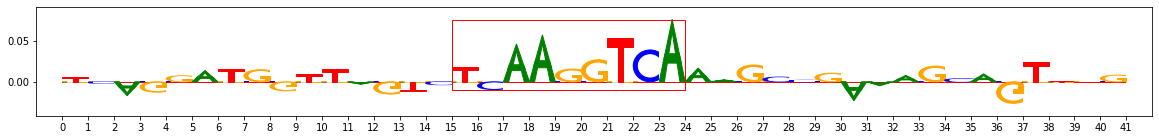

seqlet_idx 2800 max essrb cosine sim 0.936318543486119


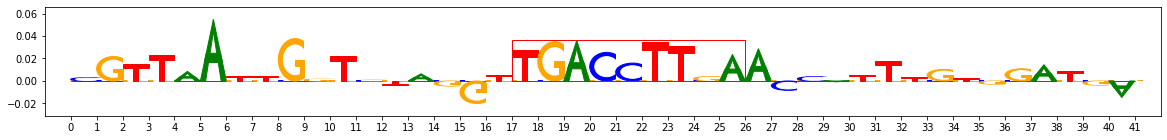

seqlet_idx 2989 max essrb cosine sim 0.8628019466968019


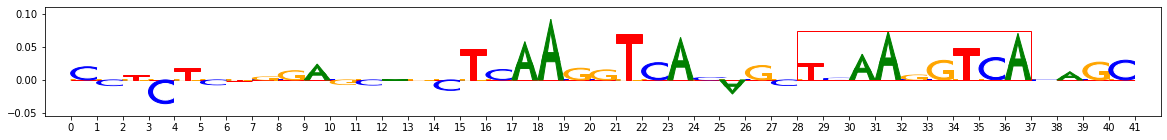

seqlet_idx 3159 max essrb cosine sim 0.8554183061543994


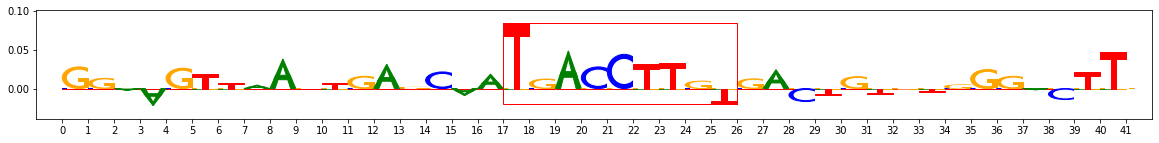

seqlet_idx 3331 max essrb cosine sim 0.8786376717967597


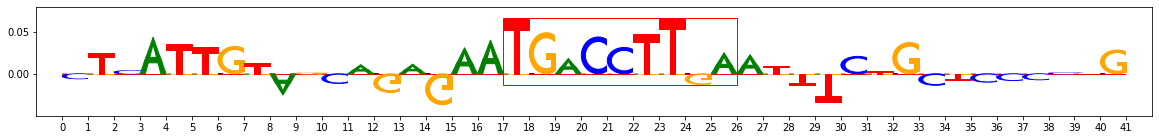

seqlet_idx 3443 max essrb cosine sim 0.8813981514828346


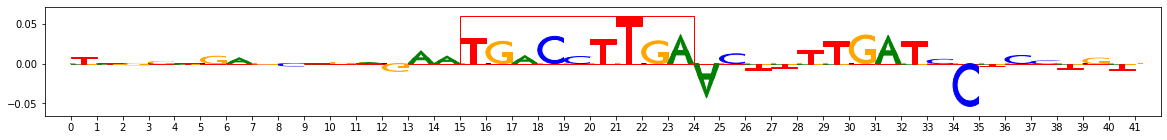

seqlet_idx 3472 max essrb cosine sim 0.8147716161308862


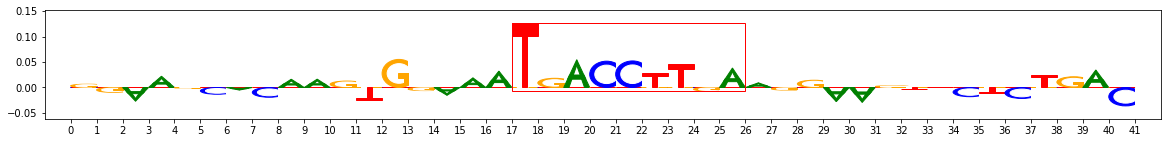

seqlet_idx 3552 max essrb cosine sim 0.96162966673921


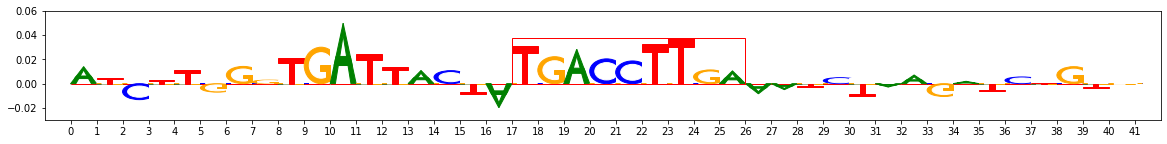

seqlet_idx 3556 max essrb cosine sim 0.8561653476827739


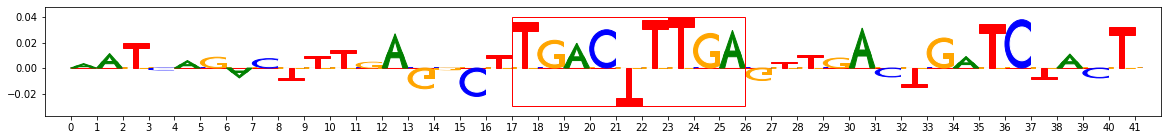

seqlet_idx 3792 max essrb cosine sim 0.9365696510890148


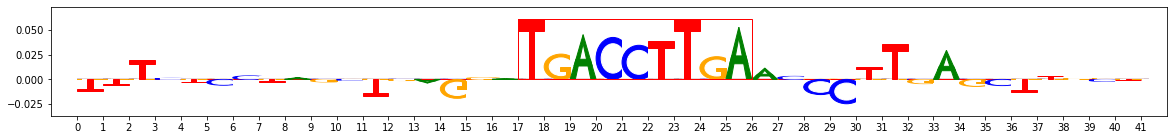

seqlet_idx 3952 max essrb cosine sim 0.9453636604934801


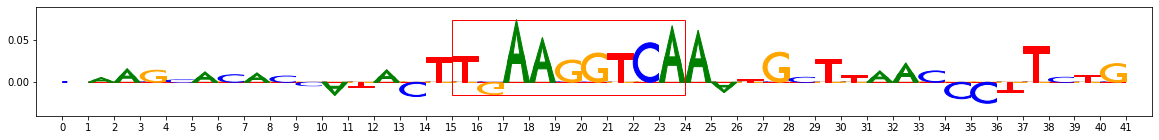

seqlet_idx 4266 max essrb cosine sim 0.9344650447514651


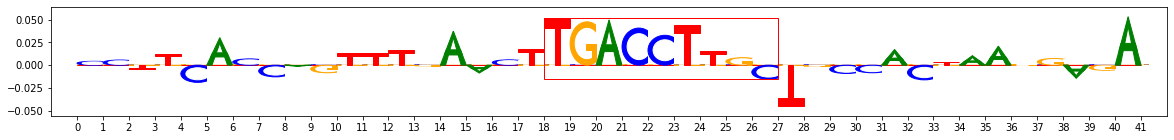

seqlet_idx 4320 max essrb cosine sim 0.9021694522333819


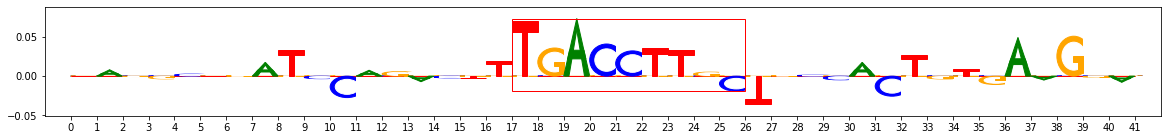

seqlet_idx 4649 max essrb cosine sim 0.9282358183170072


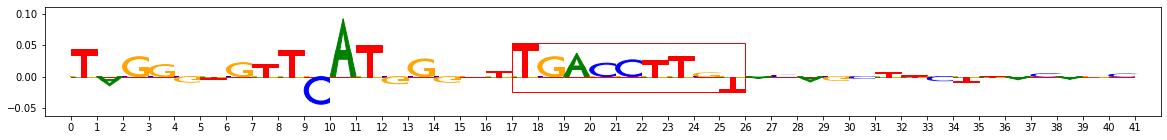

seqlet_idx 4753 max essrb cosine sim 0.9553404674891235


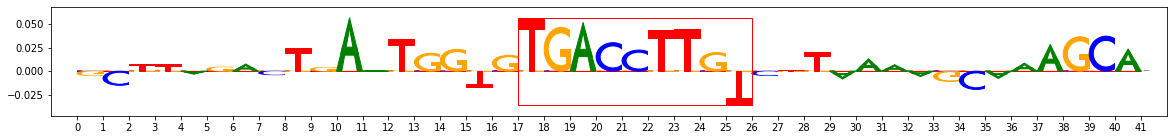

seqlet_idx 4787 max essrb cosine sim 0.9678138855773188


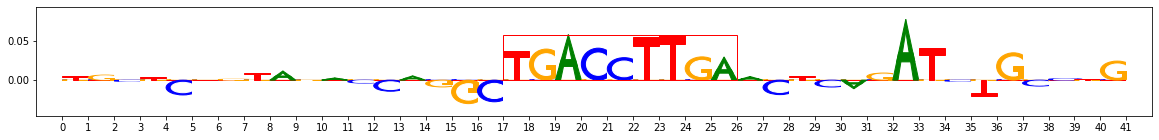

seqlet_idx 4880 max essrb cosine sim 0.7961827965263855


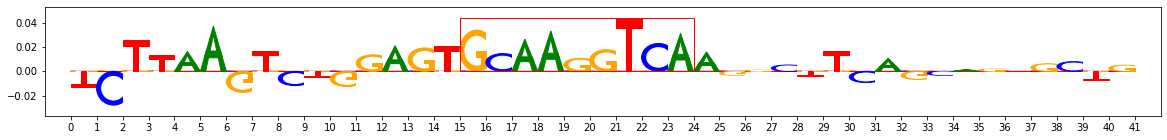

seqlet_idx 4936 max essrb cosine sim 0.8002430900339904


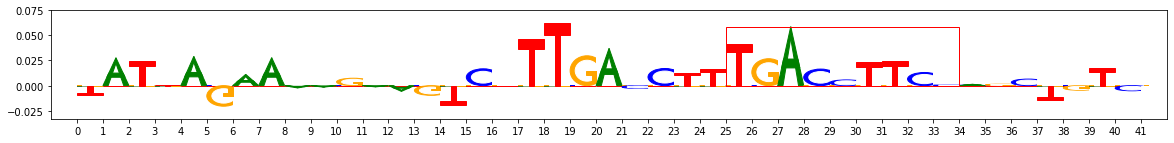

In [126]:
#inspect particular small clusters
to_inspect_clusters = [9]
for to_inspect in to_inspect_clusters:
    print("on cluster", to_inspect)
    seqlet_indices = np.arange(len(the_clustering))[the_clustering==to_inspect]
    print("Cluster size:", len(seqlet_indices))
    for seqlet_idx in seqlet_indices:
        print('seqlet_idx', seqlet_idx, 'max essrb cosine sim', np.max(esrrb_cosine_sim[seqlet_idx]))
        seqlet = seqlets_subsample[seqlet_idx]
        esrrb_cosinesim_argmaxpos = np.argmax(esrrb_cosine_sim[seqlet_idx])
        viz_sequence.plot_weights(seqlet["contrib_scores"].corefwd,
                                  highlight={'red': [(esrrb_cosinesim_argmaxpos,
                                                      esrrb_cosinesim_argmaxpos+len(esrrb_pwm))] })

In [ ]:
for idx in cluster_to_exemplars:
    if (idx==4 or idx==30):
        print("Idx", idx)
        print("Top exemplar")
        viz_sequence.plot_weights(cluster_to_exemplars[idx][0]["hypcontrib_scores"].corefwd*
                                  cluster_to_exemplars[idx][0]["onehot"].corefwd)
        within_cluster_mask = refined_clustering==idx
        #display the seqlets in ascending order of similarity
        weighted_exemplar_sims,offset,isfwdmat = cluster_to_weighted_exemplar_sims[idx]
        #get the median sim
        sortby_exemplar_sims = weighted_exemplar_sims[0,:]
        #get the sort order
        argsort_exemplar_sims = np.argsort(sortby_exemplar_sims)
        seen_within_cluster = False
        for seqlet_idx in argsort_exemplar_sims:
            if (within_cluster_mask[seqlet_idx]==True):
                seen_within_cluster = True
            sim = sortby_exemplar_sims[seqlet_idx]
            if (seen_within_cluster):
                #get the offset wrt the exemplar
                offsetwrtexemplar = offset[0, seqlet_idx]
                
                #if (within_cluster_mask[seqlet_idx]):
                if (sim > 0.5):
                    print("sim",sim,"offset",offsetwrtexemplar,
                          "within cluster", within_cluster_mask[seqlet_idx], np.mean(isfwdmat[:,seqlet_idx]))
                    
                    seqlet_hypcontrib = seqlets_subsample[seqlet_idx]["hypcontrib_scores"].get_core_with_flank(
                        left=max(offsetwrtexemplar,0),
                        right=max(-offsetwrtexemplar,0),
                        is_revcomp=isfwdmat[0, seqlet_idx]==False)[max(-offsetwrtexemplar,0):
                                                                   max(-offsetwrtexemplar,0)
                                                                   +len(seqlets_subsample[0]),:]
                    viz_sequence.plot_weights(seqlet_hypcontrib*
                                              cluster_to_exemplars[idx][0]["onehot"].corefwd)
                    if isfwdmat[0, seqlet_idx]:
                        viz_sequence.plot_weights(seqlets_subsample[seqlet_idx]["contrib_scores"].corefwd)
                    else:
                        viz_sequence.plot_weights(seqlets_subsample[seqlet_idx]["contrib_scores"].corerev)
                    #TODO: display exactly what the contin jaccard saw
                    

In [ ]:
len(seqlets_subsample[0])

In [ ]:
for cluster_idx in cluster_to_exemplars:
    if (cluster_idx==30):
        print(cluster_idx)
        unweighted_exemplars = cluster_to_unweighted_exemplars[cluster_idx]
        weighted_exemplars = cluster_to_weighted_exemplars[cluster_idx]
        for exemplaridx in range(len(weighted_exemplars)):
            print(exemplaridx)
            viz_sequence.plot_weights((unweighted_exemplars[exemplaridx]["hypcontrib_scores"].corefwd
                                       *unweighted_exemplars[exemplaridx]["onehot"].corefwd))
            viz_sequence.plot_weights((weighted_exemplars[exemplaridx]["hypcontrib_scores"].corefwd
                                       *weighted_exemplars[exemplaridx]["onehot"].corefwd))

In [ ]:

#get clusteridx->seqletpercentiles
clusterremappedidx_to_seqletpercentiles = []
newtoold_clusteridx = {}
for newclusteridx,clusteridx in enumerate(sorted(clusteridx_to_arrayforcomputingpercentile.keys())):
    exemplarindicesforcluster = clusteridx_to_exemplarindices[clusteridx]
    exemplarsims = np.max(affmat[:,exemplarindicesforcluster],axis=-1)
    arrayforcomputingpercentiles = clusteridx_to_arrayforcomputingpercentile[clusteridx]
    seqletpercentiles = (np.searchsorted(a=arrayforcomputingpercentiles,
                                         v=exemplarsims, side='right'))/(len(arrayforcomputingpercentiles))
    clusterremappedidx_to_seqletpercentiles.append(seqletpercentiles)
    newtoold_clusteridx[newclusteridx] = clusteridx

maps_to_a_cluster = (np.max(clusterremappedidx_to_seqletpercentiles, 0))>0
best_cluster_match = np.argmax(clusterremappedidx_to_seqletpercentiles, axis=0)
print("fraction mapping to a cluster:", np.mean(maps_to_a_cluster))
for newclusteridx in range(len(clusterremappedidx_to_seqletpercentiles)):
    in_cluster_mask = (best_cluster_match==newclusteridx)*maps_to_a_cluster
    
    aggregated_seqlet = get_aggregated_seqlet(
        seqlets=seqlets_subsample, in_cluster_mask=in_cluster_mask,
        distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
    seqlets_in_clust, seqletoffsets, seqletsinclust_indices =\
        get_seqlets_and_seqletoffsets_for_aggregated_seqlet(
            seqlets=seqlets_subsample, in_cluster_mask=in_cluster_mask,
            distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
    
    print("idx",newclusteridx,"size", sum(in_cluster_mask),
          "minsim", np.min(clusteridx_to_arrayforcomputingpercentile[newtoold_clusteridx[newclusteridx]]) ) 
    if (newclusteridx==12):      
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        exemplarindicesforcluster = clusteridx_to_exemplarindices[newtoold_clusteridx[newclusteridx]]
        print("the exemplars", exemplarindicesforcluster)
        for exemplaridx in exemplarindicesforcluster:
            viz_sequence.plot_weights(seqlets_subsample[exemplaridx]["contrib_scores"].corefwd)
            viz_sequence.plot_weights(seqlets_subsample[exemplaridx]["hypcontrib_scores"].corefwd)
        print("seqlets inside")
        print(seqletsinclust_indices)
        for relseqletidx in range(0,len(seqlets_in_clust),10):
            viz_sequence.plot_weights(seqlets_in_clust[relseqletidx]["contrib_scores"].corefwd)
            viz_sequence.plot_weights(seqlets_in_clust[relseqletidx]["hypcontrib_scores"].corefwd)
            print(seqletsinclust_indices[relseqletidx], "percentile", )
            print("aff:",affmat[seqletsinclust_indices[relseqletidx],exemplarindicesforcluster])
#        modisco.util.viz_seqlets_with_offsets(seqlets=seqlets_in_clust, offsets=seqletoffsets,
#                                              trackname="contrib_scores", num_to_plot=10)

#display the things mapping to each cluster.

#argmaxcluster = np.argmax(clusterremappedidx_to_seqletpercentiles, 0)
#    
#new_cluster_mapping = []
#for seqletidx in range(len(seqlets_subsample)):
#    forseqlet_clusteridx_to_percentile = {}
    
        
    

#map a seqlet to a cluster if:
# (1) its median exemplar similarity is better than that of [xth percentile] in the cluster AND
# (2) it has the highest percentile of all the clusters it maps to
#[revisit later: repeat until some kind of convergence, hopefully?]
# then use to soak
#...or could also go the SVM route...

#(Have a hypothetical exemplar?)
#hmm...how do I decide that something is not in the cluster - do I need exemplars for the outside?

#other idea: start w/ exemplars, then "grow" them out until stable assignment?
#start w. exemplars, merge based on exemplar sims to other exemplars, once merged, grow.

In [ ]:
reload(modisco.core)
reload(modisco.util)

seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets_subsample])

min_cluster_support = 20

seqlets_so_far = 0
print("Numbed of clusters:",np.max(the_clustering)+1)
for idx in range(max(the_clustering)+1):
    in_cluster_mask = idx==the_clustering
    num_in_cluster = np.sum(in_cluster_mask)
    seqlets_so_far += num_in_cluster
    print("Coverage:", )
    print("Cluster idx",idx,"size",num_in_cluster)
    if (num_in_cluster > min_cluster_support):
        #find an anchor for the cluster as the one with the minimum total distance to all the others
        #ok this doesn't work that well
        #anchor = np.argmin(np.sum(distmat[:,in_cluster_mask],axis=-1)+((in_cluster_mask==False)*np.inf))
        anchor = np.argmax(seqletimps*in_cluster_mask) #highest imp for anchor - this works better
        #sortinfo = np.argsort(seqletimps[in_cluster_mask])[::-1] #np.argsort(distmat[in_cluster_mask, anchor])
        sortinfo = np.argsort(np.median(distmat[in_cluster_mask][:,in_cluster_mask], axis=-1))
        isfwdinfo = isfwdmat[anchor, in_cluster_mask][sortinfo]
        #offsetsinfo gives the offset w.r.t. the start of anchor
        offsetsinfo = offsets[anchor, in_cluster_mask][sortinfo]
        
        seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in zip(seqlets_subsample, in_cluster_mask) if incluster]
        seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in sortinfo]
        oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                       for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
        aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:],
                                                          offsets=offsetsinfo[:])
        
        #viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].fwd
                                  - np.mean(aggregated_seqlet["hypcontrib_scores"].fwd, axis=-1)[:,None])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        #viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].rev
                                  - np.mean(aggregated_seqlet["hypcontrib_scores"].rev, axis=-1)[:,None])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].rev)
        #plot the distribution of pairwise dissimilarities within the cluster
        zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
        print("Pairwise within v pairwise out-to-within")
        plt.hist(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.hist(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Median within v median out-to-within")
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Median within, median within-to-out")
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Max within v max out-to-within")
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Max within v max within-to-out")
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)        
        plt.show()
        
        #viz some number
        """print("Visualizing seqlets")
        modisco.util.viz_seqlets_with_offsets(
            seqlets=oriented_seqlets_in_cluster,
            offsets=offsetsinfo, trackname="contrib_scores", num_to_plot=10)
        print("Done visualizing seqlets")"""
        
        #plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
        #         - np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
        #         - np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()

In [ ]:
#compare clusters
from modisco.visualization import viz_sequence
cluster1 = 0
cluster2 = 2
incluster1mask = cluster1==the_clustering
incluster2mask = cluster2==the_clustering
zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))

cluster1_within = plt.hist(zerodiagaffmat[incluster1mask][:,incluster1mask].ravel(),
                           bins=50, density=True, alpha=0.3)
cluster2_within = plt.hist(zerodiagaffmat[incluster2mask][:,incluster2mask].ravel(),
                           bins=50, density=True, alpha=0.3)
cluster12_between = plt.hist(zerodiagaffmat[incluster1mask][:,incluster2mask].ravel(),
                             bins=50, density=True, alpha=0.3)
cluster12_allelse = plt.hist(zerodiagaffmat[(incluster1mask+incluster2mask > 0)][:,(incluster1mask+incluster2mask)==0].ravel(),
                             bins=50, density=True, alpha=0.3)
plt.show()

cluster1_within = plt.hist(np.median(zerodiagaffmat[incluster1mask][:,incluster1mask],axis=-1),
                           bins=50, density=True, alpha=0.3)
cluster2_within = plt.hist(np.median(zerodiagaffmat[incluster2mask][:,incluster2mask],axis=-1),
                           bins=50, density=True, alpha=0.3)
cluster12_between = plt.hist(np.median(zerodiagaffmat[incluster1mask][:,incluster2mask],axis=-1),
                             bins=50, density=True, alpha=0.3)
cluster12_allelse = plt.hist(np.median(zerodiagaffmat[(incluster1mask+incluster2mask > 0)][:,(incluster1mask+incluster2mask)==0],axis=-1),
                             bins=50, density=True, alpha=0.3)
plt.show()

#find an example with very high within-cluster similarity but high dissim to the other cluster
cluster1typical = np.argmax(np.median(zerodiagaffmat[:,incluster1mask],axis=-1) - np.median(zerodiagaffmat[:,incluster2mask],axis=-1))
print(cluster1typical)
viz_sequence.plot_weights(seqlets_subsample[cluster1typical]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))
viz_sequence.plot_weights(seqlets_subsample[cluster1typical]["hypcontrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))

#find an example with very high within-cluster similarity but high dissim to the other cluster
cluster2typical = np.argmax(np.median(zerodiagaffmat[:,incluster2mask],axis=-1) - np.median(zerodiagaffmat[:,incluster1mask],axis=-1))
print(cluster2typical)
viz_sequence.plot_weights(seqlets_subsample[cluster2typical]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))
viz_sequence.plot_weights(seqlets_subsample[cluster2typical]["hypcontrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))